# Load Packages

In [ ]:
# Import packages
import tensorflow as tf
import keras
import numpy as np
#import sklearn as sk
import pandas as pd
import PIL
import pathlib
import os
from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras.losses import *
import requests
!pip install pyunpack patool
import pyunpack
import matplotlib.pyplot as plt
#from sklearn.preprocessing import Normalizer
from keras import backend as K
from keras.callbacks import ModelCheckpoint
from keras.applications import resnet50
import sys
!pip install rarfile
from rarfile import RarFile
!pip install segmentation-models
import segmentation_models as sm
!pip install git+https://github.com/davej23/image-segmentation-keras.git
from keras_segmentation.models import segnet
from keras.applications import vgg16
from sklearn.metrics import *
!pip install rioxarray
import rioxarray as rxr
from keras.layers.advanced_activations import LeakyReLU
from tensorflow.keras.preprocessing.image import ImageDataGenerator

     |████████████████████████████████| 81kB 7.5MB/s 
     |████████████████████████████████| 51kB 7.8MB/s 
Segmentation Models: using `keras` framework.
  Cloning https://github.com/davej23/image-segmentation-keras.git to /tmp/pip-req-build-b6y06n11
  Running command git clone -q https://github.com/davej23/image-segmentation-keras.git /tmp/pip-req-build-b6y06n11
     |████████████████████████████████| 2.9MB 14.5MB/s 
     |████████████████████████████████| 3.3MB 48.8MB/s 
     |████████████████████████████████| 952kB 44.6MB/s 
  Created wheel for keras-segmentation: filename=keras_segmentation-0.3.0-cp37-none-any.whl size=34374 sha256=cc95703fb1eff8703007d0458020f4c5c5d3514c684c1054d5d513b8b51086a6
  Stored in directory: /tmp/pip-ephem-wheel-cache-0l67vncn/wheels/ea/b4/05/f1876382a6bfc7c83e9e6b0cd91f785e0820bcb900ec750016
Successfully built keras-segmentation
ERROR: tensorflow 2.5.0 has requirement h5py~=3.1.0, but you'll have h5py 2.10.0 which is incompatible.
ERROR: albumentations 0

     |████████████████████████████████| 51kB 6.2MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 19.3MB 69.9MB/s 
     |████████████████████████████████| 6.6MB 40.3MB/s 
  Created wheel for rioxarray: filename=rioxarray-0.4.3-cp37-none-any.whl size=52339 sha256=f8365c67cbf1fa0bb0b19d6e7b4589710ccfff0957dea096246c1a0df524d928
  Stored in directory: /root/.cache/pip/wheels/68/26/80/a792c0de4d5cd92e2875cf659e600611baee21a0978b8e64bc
Successfully built rioxarray


In [ ]:
# Specify whether to download data or read in
download = True

In [ ]:
# Download data

if download:
    url = 'https://zenodo.org/record/3233081/files/Amazon%20Forest%20Dataset.rar?download=1'
    r = requests.get(url, allow_redirects=True)
    open('data.rar', 'wb').write(r.content)

    if sys.platform != 'darwin':
        pyunpack.Archive('data.rar').extractall('')

    else:
        with RarFile('data.rar') as rf:
            rf.extractall()

base_dir = r"./Amazon Forest Dataset/"

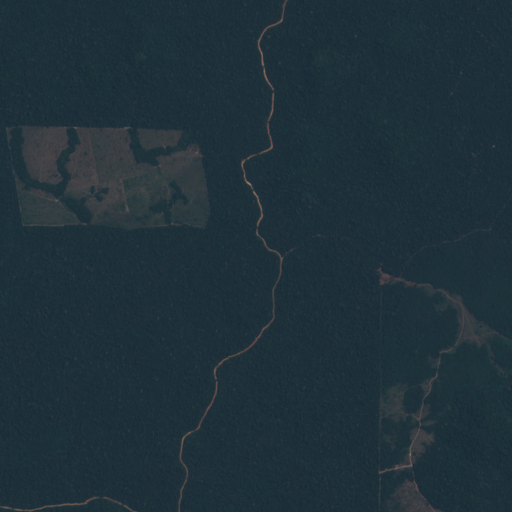

In [ ]:
# Example image from training data
PIL.Image.open(r"{}Training/images/Amazon_1110.tiff_25.tiff".format(base_dir))

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Functions

In [ ]:
def reconstruct_image(model, image, rounded=False):

  # Find model prediction
  reconstruction = model.predict(image).reshape(image.shape[1], image.shape[2])
  # Standardise between 0-1
  reconstruction = reconstruction/np.max(reconstruction)

  # Round to 0-1, binary pixel-by-pixel classification 
  if rounded:
    reconstruction = np.round(reconstruction)

  # Plot reconstructed mask (prediction)
  plt.imshow(reconstruction) 

In [ ]:
def reconstruct_array(model, image, rounded=False):

  # Find model prediction
  reconstruction = model.predict(image).reshape(image.shape[1], image.shape[2])

  if rounded:
    reconstruction = np.round(reconstruction)

  return reconstruction # Returns array

In [ ]:
def score_eval(model, image, mask): # Gives score of mask vs prediction
  if type(image) != list:   
    reconstruction = model.predict(image).reshape(mask.shape[1], mask.shape[2])
    reconstruction = np.round(reconstruction).flatten()

    return accuracy_score(mask.flatten(), reconstruction)

  else: # If a list of images input, find accuracy for each
    scores = []
    for i in range(len(image)):
      reconstruction = model.predict(image[i].reshape(1, 512, 512, 3))
      reconstruction = np.round(reconstruction).flatten()

      scores.append(accuracy_score(mask[i].flatten(), reconstruction))

    return scores

def score_eval2(model, image, mask): # Gives score of mask vs prediction
  if type(image) != list:   
    reconstruction = model.predict(image).reshape(mask.shape[1], mask.shape[2])
    reconstruction = np.round(reconstruction).flatten()

    return accuracy_score(mask.flatten(), reconstruction)

  else: # If a list of images input, find accuracy for each
    scores = []
    for i in range(len(image)):
      reconstruction = model.predict(image[i].reshape(1, 512, 512, 4))
      reconstruction = np.round(reconstruction).flatten()

      scores.append(accuracy_score(mask[i].flatten(), reconstruction))

    return scores

def recall_eval(model, image, mask): # Find recall score
  if type(image) != list:   
    reconstruction = model.predict(image).reshape(mask.shape[1], mask.shape[2])
    reconstruction = np.round(reconstruction).flatten()

    return recall_score(mask.flatten(), reconstruction, average='weighted')

  else: # If a list of images input, find accuracy for each
    recall = []
    for i in range(len(image)):
        reconstruction = model.predict(image[i]).reshape(mask[i].shape[1], mask[i].shape[2])
        reconstruction = np.round(reconstruction).flatten()

        recall.append(recall_score(mask[i].flatten(), reconstruction, average='weighted'))

    return recall

def precision_eval(model, image, mask): # Find precision score
  if type(image) != list:   
    reconstruction = model.predict(image).reshape(mask.shape[1], mask.shape[2])
    reconstruction = np.round(reconstruction).flatten()

    return precision_score(mask.flatten(), reconstruction, average='weighted')

  else: # If a list of images input, find accuracy for each
    precision = []
    for i in range(len(image)):
        reconstruction = model.predict(image[i]).reshape(mask[i].shape[1], mask[i].shape[2])
        reconstruction = np.round(reconstruction).flatten()

        precision.append(precision_score(mask[i].flatten(), reconstruction, average='weighted'))

    return precision

def f1_score_eval(model, image, mask): # Find F1-score
    prec = np.mean(precision_eval(model, image, mask))
    rec = np.mean(recall_eval(model, image, mask))

    if prec + rec == 0:
        return 0

    return 2 * (prec * rec) / (prec + rec)

def f1_score_eval_basic(precision, recall):
    prec = np.mean(precision)
    rec = np.mean(recall)

    if prec + rec == 0:
        return 0

    return 2 * (prec * rec) / (prec + rec)

def produce_mask(image): # Outputs rounded image (binary)
  return np.round(image)

In [ ]:
#
# OLD FUNCTIONS
#
'''
def score_eval(model, image, mask): # Gives score of mask vs prediction
  if type(image) != list:   
    reconstruction = model.predict(image).reshape(mask.shape[1], mask.shape[2])
    error = np.round(reconstruction).flatten() - (mask).flatten()
    return 1-(np.dot(error, error)/len(error))

  else: # If a list of images input, find accuracy for each
    scores = []
    for i in range(len(image)):
      prediction = model.predict(image[i]).reshape(mask[i].shape[1], mask[i].shape[2])
      err = np.round(prediction).flatten() - (mask[i]).flatten()
      scores.append(1-(np.dot(err, err)/len(err)))

    return scores



def recall_eval(model, image, mask): # Find recall score
  if type(image) != list:   
    reconstruction = model.predict(image).reshape(mask.shape[1], mask.shape[2])
    r = np.round(reconstruction).flatten()
    m = mask.flatten()
    zero_correct = 0
    one_correct = 0
    zero_incorrect = 0
    one_incorrect = 0
    
    for i in range(len(r)):
        if r[i] == m[i]:
            if r[i] == 0:
                zero_correct += 1
            else:
                one_correct += 1
        else:
            if r[i] == 0:
                one_incorrect += 1
            else:
                zero_incorrect += 1

    recall_zero = zero_correct/(zero_correct + one_incorrect)
    recall_one = one_correct/(one_correct + zero_incorrect)
    recall = (recall_one + recall_zero) / 2

    return recall

  else: # If a list of images input, find accuracy for each
    recall = []
    for i in range(len(image)):
        reconstruction = model.predict(image[i]).reshape(mask[i].shape[1], mask[i].shape[2])
        r = np.round(reconstruction).flatten()
        m = mask[i].flatten()

        zero_correct = 0
        one_correct = 0
        zero_incorrect = 0
        one_incorrect = 0
        
        for i in range(len(r)):
            if r[i] == m[i]:
                if r[i] == 0:
                    zero_correct += 1
                else:
                    one_correct += 1
            else:
                if r[i] == 0:
                    one_incorrect += 1
                else:
                    zero_incorrect += 1

        recall_zero = zero_correct/(zero_correct + one_incorrect)
        recall_one = one_correct/(one_correct + zero_incorrect)
        recall.append((recall_one + recall_zero) / 2)

    return recall


def precision_eval(model, image, mask): # Find precision score
  if type(image) != list:   
    reconstruction = model.predict(image).reshape(mask.shape[1], mask.shape[2])
    r = np.round(reconstruction).flatten()
    m = mask.flatten()
    zero_correct = 0
    one_correct = 0
    zero_incorrect = 0
    one_incorrect = 0
    
    for i in range(len(r)):
        if r[i] == m[i]:
            if r[i] == 0:
                zero_correct += 1
            else:
                one_correct += 1
        else:
            if r[i] == 0:
                one_incorrect += 1
            else:
                zero_incorrect += 1

    precision_zero = zero_correct/(zero_correct + zero_incorrect)
    precision_one = one_correct/(one_correct + one_incorrect)
    precision = (precision_one + precision_zero) / 2

    return precision

  else: # If a list of images input, find accuracy for each
    precision = []
    for i in range(len(image)):
        reconstruction = model.predict(image[i]).reshape(mask[i].shape[1], mask[i].shape[2])
        r = np.round(reconstruction).flatten()
        m = mask[i].flatten()

        zero_correct = 0
        one_correct = 0
        zero_incorrect = 0
        one_incorrect = 0
        
        for i in range(len(r)):
            if r[i] == m[i]:
                if r[i] == 0:
                    zero_correct += 1
                else:
                    one_correct += 1
            else:
                if r[i] == 0:
                    one_incorrect += 1
                else:
                    zero_incorrect += 1

        precision_zero = zero_correct/(zero_correct + zero_incorrect)
        precision_one = one_correct/(one_correct + one_incorrect)
        precision.append((precision_one + precision_zero) / 2)

    return precision


def f1_score_eval(model, image, mask): # Find F1-score
    prec = np.mean(precision_eval(model, image, mask))
    rec = np.mean(recall_eval(model, image, mask))
    return 2 * (prec * rec) / (prec + rec)

def f1_score_eval_basic(precision, recall):
    prec = np.mean(precision)
    rec = np.mean(recall)
    return 2 * (prec * rec) / (prec + rec)

def produce_mask(image): # Outputs rounded image (binary)
  return np.round(image)

'''

'\ndef score_eval(model, image, mask): # Gives score of mask vs prediction\n  if type(image) != list:   \n    reconstruction = model.predict(image).reshape(mask.shape[1], mask.shape[2])\n    error = np.round(reconstruction).flatten() - (mask).flatten()\n    return 1-(np.dot(error, error)/len(error))\n\n  else: # If a list of images input, find accuracy for each\n    scores = []\n    for i in range(len(image)):\n      prediction = model.predict(image[i]).reshape(mask[i].shape[1], mask[i].shape[2])\n      err = np.round(prediction).flatten() - (mask[i]).flatten()\n      scores.append(1-(np.dot(err, err)/len(err)))\n\n    return scores\n\n\n\ndef recall_eval(model, image, mask): # Find recall score\n  if type(image) != list:   \n    reconstruction = model.predict(image).reshape(mask.shape[1], mask.shape[2])\n    r = np.round(reconstruction).flatten()\n    m = mask.flatten()\n    zero_correct = 0\n    one_correct = 0\n    zero_incorrect = 0\n    one_incorrect = 0\n    \n    for i in range(

# Ingest and Process Amazon RGB Dataset

In [ ]:
# Ingest images

## Training images
training_images_list = os.listdir(r"{}Training/images/".format(base_dir))
training_masks_list = []
training_images = []
for n in training_images_list:
  im = PIL.Image.open(r"{}Training/images/{}".format(base_dir,n))
  training_images.append(im)
  training_masks_list.append(n[:-5]+'.png')

## Training masks
training_masks = []
for n in training_masks_list:
  im = PIL.Image.open(r"{}Training/masks/{}".format(base_dir,n))
  training_masks.append(im)

## Test images
test_images_list = os.listdir(r"{}Test/".format(base_dir))
test_images = []
for n in test_images_list:
  im = PIL.Image.open(r"{}Test/{}".format(base_dir,n))
  test_images.append(im)

## Validation images
validation_images_list = os.listdir(r"{}Validation/images/".format(base_dir))
validation_masks_list = []
validation_images = []
for n in validation_images_list:
  im = PIL.Image.open(r"{}Validation/images/{}".format(base_dir,n))
  validation_images.append(im)
  validation_masks_list.append(n[:-5]+'.png')

## Validation masks
validation_masks = []
for n in validation_masks_list:
  im = PIL.Image.open(r"{}Validation/masks/{}".format(base_dir,n))
  validation_masks.append(im)

In [ ]:
# Pre-process data
for i in range(len(training_images)):
  training_images[i] = np.array(training_images[i])/255
  training_images[i] = training_images[i].reshape(512,512,3)
  training_images[i] = training_images[i].astype('float32')

for i in range(len(training_masks)):
  training_masks[i] = (np.array(training_masks[i])-1)
  training_masks[i] = training_masks[i][:512,:512]
  training_masks[i] = training_masks[i].reshape(512,512,1)
  training_masks[i] = training_masks[i].astype('int')

for i in range(len(validation_images)):
  validation_images[i] = np.array(validation_images[i])/255
  validation_images[i] = validation_images[i].reshape(1,512,512,3)
  validation_images[i] = validation_images[i].astype('float32')

for i in range(len(validation_masks)):
  validation_masks[i] = np.array(validation_masks[i])-1
  validation_masks[i] = validation_masks[i][:512,:512]
  validation_masks[i] = validation_masks[i].reshape(1,512,512,1)
  validation_masks[i] = validation_masks[i].astype('int')

for i in range(len(test_images)):
  test_images[i] = np.array(test_images[i])/255
  test_images[i] = test_images[i].reshape(512,512,3)
  test_images[i] = test_images[i].astype('float32')

In [ ]:
# Create TensorFlow datasets for training and validation sets
#train_df = tf.data.Dataset.from_tensor_slices((training_images, training_masks))
validation_df = tf.data.Dataset.from_tensor_slices((validation_images, validation_masks))

In [ ]:
# Load in augmented images (capped at 500 for sake of RAM limits in Colab)
# Ingest images
'''
## Training images
training_images_augmented = []
training_masks_augmented = []
for n in os.listdir(r"augmented/images/")[0:500]:
  im = PIL.Image.open(r"augmented/images/{}".format(n))
  im = np.array(im)/255
  im = im.reshape(1,512,512,3)
  im = im.astype('float32')
  training_images_augmented.append(im)

  im2 = PIL.Image.open(r"augmented/masks/{}".format(n))
  im2 = np.round(np.array(im2)/255)
  im2 = im2[:512,:512]
  im2 = im2.reshape(1,512,512,1)
  im2 = im2.astype('float32')
  training_masks_augmented.append(im2)

# Create TensorFlow datasets for training and validation sets
train_df = tf.data.Dataset.from_tensor_slices((training_images_augmented, training_masks_augmented))
validation_df = tf.data.Dataset.from_tensor_slices((validation_images, validation_masks))
'''

'\n## Training images\ntraining_images_augmented = []\ntraining_masks_augmented = []\nfor n in os.listdir(r"augmented/images/")[0:500]:\n  im = PIL.Image.open(r"augmented/images/{}".format(n))\n  im = np.array(im)/255\n  im = im.reshape(1,512,512,3)\n  im = im.astype(\'float32\')\n  training_images_augmented.append(im)\n\n  im2 = PIL.Image.open(r"augmented/masks/{}".format(n))\n  im2 = np.round(np.array(im2)/255)\n  im2 = im2[:512,:512]\n  im2 = im2.reshape(1,512,512,1)\n  im2 = im2.astype(\'float32\')\n  training_masks_augmented.append(im2)\n\n# Create TensorFlow datasets for training and validation sets\ntrain_df = tf.data.Dataset.from_tensor_slices((training_images_augmented, training_masks_augmented))\nvalidation_df = tf.data.Dataset.from_tensor_slices((validation_images, validation_masks))\n'

In [ ]:
#
# Data loader from: https://github.com/bragagnololu/UNet-defmapping.git
#

def adjustData(img, mask, num_class):
  
    mask[mask > 0.5] = 1 # FOREST
    mask[mask <= 0.5] = 0 # NON-FOREST

    return (img,mask)

def trainGenerator(batch_size,
                   image_array,
                   mask_array,
                   aug_dict,
                   image_save_prefix  = "image",
                   mask_save_prefix  = "mask",
                   num_class = 2,
                   save_to_dir = None,
                   target_size = (512,512),
                   seed = 1):

    image_datagen = ImageDataGenerator(**aug_dict)
    mask_datagen = ImageDataGenerator(**aug_dict)

    image_generator = image_datagen.flow(image_array,
                                           batch_size = batch_size,
                                           save_to_dir = save_to_dir,
                                           save_prefix = image_save_prefix,
                                           seed = seed) 

    mask_generator = mask_datagen.flow(mask_array,
                                           batch_size = batch_size,
                                           save_to_dir = save_to_dir,
                                           save_prefix = mask_save_prefix,
                                           seed = seed)
    
    train_generator = zip(image_generator, mask_generator)
    
    for (img,mask) in train_generator: 
        img, mask = adjustData(img, mask, num_class)
        yield (img, mask)

In [ ]:
#
# Produce generators for training images
#

t_images = np.stack(training_images)
t_masks = np.stack(training_masks)

v_images = np.stack(validation_images)
v_masks = np.stack(validation_masks)

data_gen_args = dict(rotation_range=180,
                    width_shift_range=0.5,
                    height_shift_range=0.5,
                    shear_range=0.2,
                    zoom_range=0.25,
                    horizontal_flip=True,
                    vertical_flip = True,
                    fill_mode='reflect',
                    )

train = trainGenerator(1, t_images, t_masks, data_gen_args, save_to_dir=None)
#validation = trainGenerator(1, v_images, v_masks, data_gen_args, save_to_dir=None)

In [ ]:
# Show example of augmented image

#x_batch, y_batch = next(train)
#plt.imshow(x_batch.reshape(512,512,3))

In [ ]:
#np.mean(score_eval(model1, validation_images, validation_masks))

In [ ]:
#np.mean(score_eval(model2, validation_images, validation_masks))

# Ingest and Process 4-band Datasets

## 4-band Amazon dataset

https://zenodo.org/record/4498086#.YMh3GfKSmCU

In [ ]:
# Download data (Amazon)
download = True # True if files don't already exist in same directory
if download:
    url = 'https://zenodo.org/record/4498086/files/AMAZON.rar?download=1'
    r = requests.get(url, allow_redirects=True)
    open('data2.rar', 'wb').write(r.content)

    if sys.platform != 'darwin':
        pyunpack.Archive('data2.rar').extractall('')

    else:
        with RarFile('data2.rar') as rf:
            rf.extractall()

base_dir2 = r"./AMAZON/"

In [ ]:
# Ingest images

## Training images
training_images_list2 = os.listdir(r"{}Training/image/".format(base_dir2))[0:250]
training_masks_list2 = []
training_images2 = []
for n in training_images_list2:
  training_masks_list2.append(n)
  a = (np.array(rxr.open_rasterio(r"{}Training/image/{}".format(base_dir2,n))))
  a = (a-np.min(a)) / (np.max(a)-np.min(a))
  training_images2.append(a)

## Training masks
training_masks2 = []
for n in training_masks_list2:
  a = (np.array(rxr.open_rasterio(r"{}Training/label/{}".format(base_dir2,n))))
  training_masks2.append(a)

## Test images
test_images_list2 = os.listdir(r"{}Test/image/".format(base_dir2))
test_masks_list2 = []
test_images2 = []
for n in test_images_list2:
  test_masks_list2.append(n)
  a = (np.array(rxr.open_rasterio(r"{}Test/image/{}".format(base_dir2,n))))
  a = (a-np.min(a)) / (np.max(a)-np.min(a))
  test_images2.append(a)

## Test masks
test_masks2 = []
for n in test_masks_list2:
  a = (np.array(rxr.open_rasterio(r"{}Test/mask/{}".format(base_dir2,n))))
  test_masks2.append(a)

## Validation images
validation_images_list2 = os.listdir(r"{}Validation/images/".format(base_dir2))
validation_masks_list2 = []
validation_images2 = []
for n in validation_images_list2:
  validation_masks_list2.append(n)
  a = (np.array(rxr.open_rasterio(r"{}Validation/images/{}".format(base_dir2,n))))
  a = (a-np.min(a)) / (np.max(a)-np.min(a))
  validation_images2.append(a)

## Validation masks
validation_masks2 = []
for n in validation_masks_list2:
  a = (np.array(rxr.open_rasterio(r"{}Validation/masks/{}".format(base_dir2,n))))
  validation_masks2.append(a)

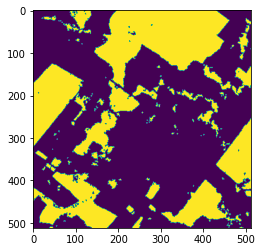

In [ ]:
a = (np.array(rxr.open_rasterio(r"{}Training/label/{}".format(base_dir2,training_masks_list2[20])))[0,:,:])
plt.imshow(a)

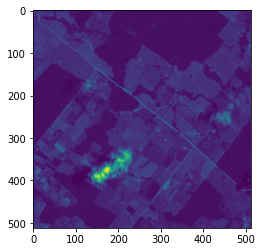

In [ ]:
plt.imshow((np.array(rxr.open_rasterio(r"{}Training/image/{}".format(base_dir2,training_images_list2[20])))[0,:,:]))

(512, 512, 4)


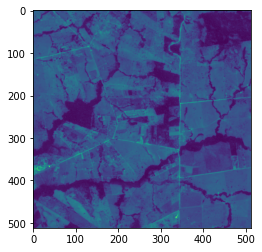

In [ ]:
b = training_images2[0].T
print(b.shape)
plt.imshow(b[:,:,0])

(512, 512, 4)


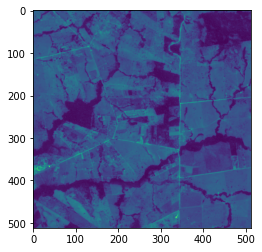

In [ ]:
c = b.reshape(1,512,512,4)
d = c.reshape(512,512,4)
print(d.shape)
plt.imshow(d[:,:,0])

(512, 512, 1)


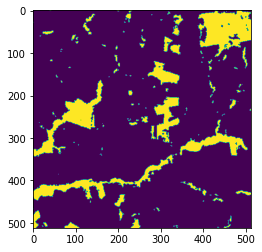

In [ ]:
a = training_masks2[0].T
print(a.shape)
plt.imshow(a.reshape(512,512))

In [ ]:
# Pre-process data
for i in range(len(training_images2)):
  #training_images2[i] = training_images2[i].reshape(1,512,512,4)
  training_images2[i] = training_images2[i].astype('float32')
  training_images2[i] = training_images2[i].T

for i in range(len(training_masks2)):
  #training_masks[i] = training_masks[i][:512,:512]
  training_masks2[i] = training_masks2[i].reshape(1,512,512,1)
  training_masks2[i] = training_masks2[i].T

for i in range(len(validation_images2)):
  #validation_images2[i] = validation_images2[i].reshape(1,512,512,4)
  validation_images2[i] = validation_images2[i].astype('float32')
  validation_images2[i] = validation_images2[i].T

for i in range(len(validation_masks2)):
  #validation_masks2[i] = validation_masks2[i][:512,:512]
  validation_masks2[i] = validation_masks2[i].reshape(1,512,512,1)
  validation_masks2[i] = validation_masks2[i].T

for i in range(len(test_images2)):
  #test_images2[i] = test_images2[i].reshape(1,512,512,4)
  test_images2[i] = test_images2[i].astype('float32')
  test_images2[i] = test_images2[i].T

for i in range(len(test_masks2)):
  #test_masks2[i] = test_masks2[i][:512,:512]
  test_masks2[i] = test_masks2[i].reshape(1,512,512,1)
  test_masks2[i] = test_masks2[i].T


for i in range(len(training_images2)):
  training_images2[i] = training_images2[i].reshape(-1,512,512,4)

for i in range(len(validation_images2)):
  validation_images2[i] = validation_images2[i].reshape(-1,512,512,4)

for i in range(len(test_images2)):
  test_images2[i] = test_images2[i].reshape(-1,512,512,4)

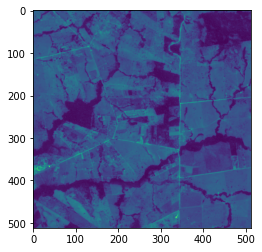

In [ ]:
plt.imshow(training_images2[0].reshape(512,512,4)[:,:,0])

In [ ]:
# Create TensorFlow datasets for training and validation sets
train_df_4band_amazon = tf.data.Dataset.from_tensor_slices((training_images2[0:250], training_masks2[0:250]))
validation_df_4band_amazon = tf.data.Dataset.from_tensor_slices((validation_images2, validation_masks2))

## 4-band Atlantic Forest dataset

https://zenodo.org/record/4498086/files/ATLANTIC%20FOREST.rar?download=1

In [ ]:
# Download data (Atlantic Forest)
download = True # True if files don't already exist in same directory
if download:
    url = 'https://zenodo.org/record/4498086/files/ATLANTIC%20FOREST.rar?download=1'
    r = requests.get(url, allow_redirects=True)
    open('data3.rar', 'wb').write(r.content)

    if sys.platform != 'darwin':
        pyunpack.Archive('data3.rar').extractall('')

    else:
        with RarFile('data3.rar') as rf:
            rf.extractall()

base_dir3 = r"./ATLANTIC FOREST/"

In [ ]:
# Ingest images

## Training images
training_images_list3 = os.listdir(r"{}Training/image/".format(base_dir3))[0:250]
training_masks_list3 = []
training_images3 = []
for n in training_images_list3:
  training_masks_list3.append(n)
  a = (np.array(rxr.open_rasterio(r"{}Training/image/{}".format(base_dir3,n))))
  a = (a-np.min(a)) / (np.max(a)-np.min(a))
  training_images3.append(a)

## Training masks
training_masks3 = []
for n in training_masks_list3:
  a = (np.array(rxr.open_rasterio(r"{}Training/label/{}".format(base_dir3,n))))
  training_masks3.append(a)

## Test images
test_images_list3 = os.listdir(r"{}Test/image/".format(base_dir3))
test_masks_list3 = []
test_images3 = []
for n in test_images_list3:
  test_masks_list3.append(n)
  a = (np.array(rxr.open_rasterio(r"{}Test/image/{}".format(base_dir3,n))))
  a = (a-np.min(a)) / (np.max(a)-np.min(a))
  test_images3.append(a)

## Test masks
test_masks3 = []
for n in test_masks_list3:
  a = (np.array(rxr.open_rasterio(r"{}Test/mask/{}".format(base_dir3,n))))
  test_masks3.append(a)

## Validation images
validation_images_list3 = os.listdir(r"{}Validation/images/".format(base_dir3))
validation_masks_list3 = []
validation_images3 = []
for n in validation_images_list3:
  validation_masks_list3.append(n)
  a = (np.array(rxr.open_rasterio(r"{}Validation/images/{}".format(base_dir3,n))))
  a = (a-np.min(a)) / (np.max(a)-np.min(a))
  validation_images3.append(a)

## Validation masks
validation_masks3 = []
for n in validation_masks_list3:
  a = (np.array(rxr.open_rasterio(r"{}Validation/masks/{}".format(base_dir3,n))))
  validation_masks3.append(a)

In [ ]:
# Pre-process data
for i in range(len(training_images3)):
  #training_images3[i] = training_images3[i].reshape(1,512,512,4)
  training_images3[i] = training_images3[i].astype('float32')
  training_images3[i] = training_images3[i].T

for i in range(len(training_masks3)):
  #training_masks3[i] = training_masks3[i][:512,:512]
  training_masks3[i] = training_masks3[i].reshape(1,512,512,1)
  training_masks3[i] = training_masks3[i].T

for i in range(len(validation_images3)):
  #validation_images3[i] = validation_images3[i].reshape(1,512,512,4)
  validation_images3[i] = validation_images3[i].astype('float32')
  validation_images3[i] = validation_images3[i].T

for i in range(len(validation_masks3)):
  #validation_masks3[i] = validation_masks3[i][:512,:512]
  validation_masks3[i] = validation_masks3[i].reshape(1,512,512,1)
  validation_masks3[i] = validation_masks3[i].T

for i in range(len(test_images3)):
  #test_images3[i] = test_images3[i].reshape(1,512,512,4)
  test_images3[i] = test_images3[i].astype('float32')
  test_images3[i] = test_images3[i].T

for i in range(len(test_masks3)):
  #test_masks3[i] = test_masks3[i][:512,:512]
  test_masks3[i] = test_masks3[i].reshape(1,512,512,1)
  test_masks3[i] = test_masks3[i].T


for i in range(len(training_images3)):
  training_images3[i] = training_images3[i].reshape(-1,512,512,4)

for i in range(len(validation_images3)):
  validation_images3[i] = validation_images3[i].reshape(-1,512,512,4)

for i in range(len(test_images3)):
  test_images3[i] = test_images3[i].reshape(-1,512,512,4)

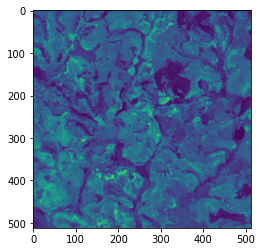

In [ ]:
plt.imshow(training_images3[0].reshape(512,512,4)[:,:,0])

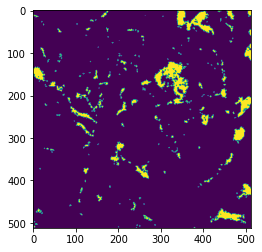

In [ ]:
plt.imshow(training_masks3[0].reshape(512,512,1)[:,:,0])

In [ ]:
# Create TensorFlow datasets for training and validation sets
train_df_4band_atlantic = tf.data.Dataset.from_tensor_slices((training_images3[0:250], training_masks3[0:250]))
validation_df_4band_atlantic = tf.data.Dataset.from_tensor_slices((validation_images3, validation_masks3))

# Models

## U-Net

In [ ]:
def convBlock(input, filters, kernel, kernel_init='he_normal', act='relu', transpose=False):
  if transpose == False:
    #conv = ZeroPadding2D((1,1))(input)
    conv = Conv2D(filters, kernel, padding = 'same', kernel_initializer = kernel_init)(input)
  else:
    #conv = ZeroPadding2D((1,1))(input)
    conv = Conv2DTranspose(filters, kernel, padding = 'same', kernel_initializer = kernel_init)(input)

  conv = Activation(act)(conv)
  return conv
  
def UNet(trained_weights = None, input_size = (512,512,4), drop_rate = 0.25, lr=0.0001):

    # Code modified from https://github.com/zhixuhao/unet
    ## Can add pretrained weights by specifying 'trained_weights'

    # Input layer
    inputs = Input(input_size, batch_size=1)

    # Hidden layers
    ## Contraction phase
    conv1 = convBlock(inputs, 64, 3)
    conv1 = convBlock(conv1, 64, 3)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = convBlock(pool1, 128, 3)
    conv2 = convBlock(conv2, 128, 3)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    #drop2 = Dropout(drop_rate)(pool2)

    conv3 = convBlock(pool2, 256, 3)
    conv3 = convBlock(conv3, 256, 3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    #drop3 = Dropout(drop_rate)(pool3)

    conv4 = convBlock(pool3, 512, 3)
    conv4 = convBlock(conv4, 512, 3)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)
    #drop4 = Dropout(drop_rate)(pool4)

    conv5 = convBlock(pool4, 1024, 3)
    conv5 = convBlock(conv5, 1024, 3)

    ## Expansion phase
    up6 = (UpSampling2D(size = (2,2))(conv5))
    merge6 = concatenate([conv4,up6])
    conv6 = convBlock(merge6, 512, 3)
    conv6 = convBlock(conv6, 512, 3)
    #conv6 = Dropout(drop_rate)(conv6)

    up7 = (UpSampling2D(size = (2,2))(conv6))
    merge7 = concatenate([conv3,up7])
    conv7 = convBlock(merge7, 256, 3)
    conv7 = convBlock(conv7, 256, 3)
    #conv7 = Dropout(drop_rate)(conv7)

    up8 = (UpSampling2D(size = (2,2))(conv7))
    merge8 = concatenate([conv2,up8])
    conv8 = convBlock(merge8, 128, 3)
    conv8 = convBlock(conv8, 128, 3)
    #conv8 = Dropout(drop_rate)(conv8)

    up9 = (UpSampling2D(size = (2,2))(conv8))
    merge9 = concatenate([conv1,up9])
    conv9 = convBlock(merge9, 64, 3)
    conv9 = convBlock(conv9, 64, 3)
    conv10 = convBlock(conv9, 1, 1, act='sigmoid')


    model = Model(inputs, conv10)

    model.compile(optimizer = Adam(learning_rate = lr), loss = 'binary_crossentropy', metrics = ['accuracy', 'mse'])

    if trained_weights != None:
    	model.load_weights(trained_weights)

    return model

In [ ]:
UNet().summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(1, 512, 512, 4)]   0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (1, 512, 512, 64)    2368        input_1[0][0]                    
__________________________________________________________________________________________________
activation (Activation)         (1, 512, 512, 64)    0           conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (1, 512, 512, 64)    36928       activation[0][0]                 
______________________________________________________________________________________________

## Attention U-Net

**Refs**

https://github.com/bragagnololu/UNet-defmapping.git

https://www.kaggle.com/bigironsphere/loss-function-library-keras-pytorch

https://arxiv.org/abs/2004.03696

https://github.com/MoleImg/Attention_UNet.git

https://www.researchgate.net/publication/343739732_Enhancing_U-Net_with_Spatial-Channel_Attention_Gate_for_Abnormal_Tissue_Segmentation_in_Medical_Imaging

https://arxiv.org/abs/2004.03696

In [ ]:
def DiceBCELoss(targets, inputs, smooth=1e-6):    
       
    inputs = K.flatten(inputs)
    targets = K.flatten(targets)

    inputs = tf.cast(inputs, tf.float32)
    targets = tf.cast(targets, tf.float32)
    
    BCE =  binary_crossentropy(targets, inputs)
    intersection = K.sum(targets * inputs)   
    dice_loss = 1 - (2*intersection + smooth) / (K.sum(targets) + K.sum(inputs) + smooth)
    Dice_BCE = BCE + dice_loss
    
    return Dice_BCE

def DiceLoss(targets, inputs, smooth=1e-6):
    
    inputs = K.flatten(inputs)
    targets = K.flatten(targets)

    inputs = tf.cast(inputs, tf.float32)
    targets = tf.cast(targets, tf.float32)
    
    intersection = K.sum(targets * inputs)
    dice = (2*intersection + smooth) / (K.sum(targets) + K.sum(inputs) + smooth)
    return 1 - dice

def convBlock2(input, filters, kernel, kernel_init='he_normal', act='relu', transpose=False):
  if transpose == False:
    conv = Conv2D(filters, kernel, padding = 'same', kernel_initializer = kernel_init)(input)
    conv = Activation(act)(conv)
    conv = Conv2D(filters, kernel, padding = 'same', kernel_initializer = kernel_init)(conv)
    conv = Activation(act)(conv)
  else:
    conv = Conv2DTranspose(filters, kernel, padding = 'same', kernel_initializer = kernel_init)(input)
    conv = Activation(act)(conv)
    conv = Conv2DTranspose(filters, kernel, padding = 'same', kernel_initializer = kernel_init)(conv)
    conv = Activation(act)(conv)

  return conv
  
def spatial_attention(x):

  avg_pool = Lambda(lambda x: K.mean(x, axis=3, keepdims=True))(x)
  max_pool = Lambda(lambda x: K.max(x, axis=3, keepdims=True))(x)

  concat = concatenate([avg_pool, max_pool], axis=3)

  #out = convBlock(concat, 2, 2, act='sigmoid')
  out = Conv2D(1, kernel_size = 1, strides = 1, padding = 'same', kernel_initializer = 'he_normal')(concat)
  out = Activation('sigmoid')(out)

  out = multiply([x, out])

  return out


def attention_block(x, gating, inter_shape, drop_rate=0.25):
    
    shape_x = K.int_shape(x)
    shape_g = K.int_shape(gating)


    # Initial gate
    theta_x = Conv2D(inter_shape, kernel_size = 1, strides = 1, padding='same', kernel_initializer='he_normal')(x)
    theta_x = MaxPooling2D((2,2))(theta_x)
    #theta_x = Conv2D(inter_shape, kernel_size = 1, strides = 1, padding='same', kernel_initializer='he_normal')(x)
    shape_theta_x = K.int_shape(theta_x)

    phi_g = Conv2D(inter_shape, kernel_size = 1, strides = 1, padding='same', kernel_initializer='he_normal')(gating)
    shape_phi_g = K.int_shape(phi_g)

    # Add components
    concat_xg = add([phi_g, theta_x])
    act_xg = Activation('relu')(concat_xg)

    # Apply convolution
    psi = Conv2D(1, kernel_size = 1, strides = 1, padding='same', kernel_initializer='he_normal')(act_xg)

    # Apply sigmoid activation
    sigmoid_xg = Activation('sigmoid')(psi)
    shape_sigmoid = K.int_shape(sigmoid_xg)

    # UpSample (Resampling) to correct size
    upsample_psi = UpSampling2D(size=(shape_x[1] // shape_sigmoid[1], shape_x[2] // shape_sigmoid[2]))(sigmoid_xg)
    y = multiply([upsample_psi, x])

    #y = Conv2D(1, 1, padding='same', kernel_initializer='he_normal')(y)
    #y = Activation('sigmoid')(y)

    return y


def UNetAM(trained_weights = None, input_size = (512,512,3), drop_rate = 0.25, lr=0.0001, filter_base=64):

    # Code modified from https://github.com/zhixuhao/unet
    ## Can add pretrained weights by specifying 'trained_weights'

    # Input layer
    inputs = Input(input_size, batch_size=1)

    # Hidden layers
    ## Contraction phase
    conv0 = convBlock2(inputs, filter_base, 3)
    #conv0 = Dropout(drop_rate)(conv0)

    pool0 = MaxPooling2D(pool_size=(2, 2))(conv0)
    conv1 = convBlock2(pool0, 2 * filter_base, 3)
    #conv1 = Dropout(drop_rate)(conv1)

    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = convBlock2(pool1, 4 * filter_base, 3)
    #conv2 = Dropout(drop_rate)(conv2)

    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = convBlock2(pool2, 8 * filter_base, 3)
    #conv3 = Dropout(drop_rate)(conv3)

    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    conv4 = convBlock2(pool3, 16 * filter_base, 3)
    #spatial1 = spatial_attention(conv4)

    ## Expansion phase
    up5 = (UpSampling2D(size = (2,2))(conv4))
    merge5 = attention_block(conv3, conv4, 8 * filter_base, drop_rate) # Attention gate
    conv5 = concatenate([up5, merge5])
    conv5 = convBlock2(conv5, 4 * filter_base, 3)

    up6 = (UpSampling2D(size = (2,2))(conv5))
    merge6 = attention_block(conv2, conv5, 4 * filter_base, drop_rate) # Attention gate
    conv6 = concatenate([up6, merge6])
    conv6 = convBlock2(conv6, 2 * filter_base, 3)

    up7 = (UpSampling2D(size = (2,2))(conv6))
    merge7 = attention_block(conv1, conv6, 2 * filter_base, drop_rate) # Attention gate
    conv7 = concatenate([up7, merge7])
    conv7 = convBlock2(conv7, filter_base, 3)

    up8 = (UpSampling2D(size = (2,2))(conv7))
    merge8 = attention_block(conv0, conv7, filter_base, drop_rate) # Attention gate
    conv8 = concatenate([up8, merge8])
    conv8 = convBlock2(conv8, filter_base, 3)
    
    conv9 = convBlock(conv8, 1, 1, act='sigmoid')

    model = Model(inputs, conv9)

    model.compile(optimizer = Adam(learning_rate = lr), loss = binary_crossentropy, metrics = ['accuracy', 'mse'])

    if trained_weights != None:
    	model.load_weights(trained_weights)

    return model

In [ ]:
UNetAM().summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(1, 512, 512, 3)]   0                                            
__________________________________________________________________________________________________
conv2d_19 (Conv2D)              (1, 512, 512, 64)    1792        input_2[0][0]                    
__________________________________________________________________________________________________
activation_19 (Activation)      (1, 512, 512, 64)    0           conv2d_19[0][0]                  
__________________________________________________________________________________________________
conv2d_20 (Conv2D)              (1, 512, 512, 64)    36928       activation_19[0][0]              
____________________________________________________________________________________________

# Train on RGB feature data

## U-Net

In [ ]:
# Train U-Net with generator
model_unet = UNet(input_size=(512,512,3), lr=0.0001)
save_model = ModelCheckpoint('unet-3d.hdf5', monitor='val_accuracy',verbose=1, save_best_only=True)
train = trainGenerator(1, t_images, t_masks, data_gen_args, save_to_dir=None)
model_unet.fit(train, steps_per_epoch=100, epochs=50, validation_data = validation_df, callbacks=[save_model])

Epoch 1/50
100/100 [==============================] - 18s 146ms/step - loss: 0.5919 - accuracy: 0.7011 - mse: 0.2058 - val_loss: 0.2940 - val_accuracy: 0.8838 - val_mse: 0.0880

Epoch 00001: val_accuracy improved from -inf to 0.88378, saving model to unet.hdf5
Epoch 2/50
100/100 [==============================] - 14s 137ms/step - loss: 0.2400 - accuracy: 0.9146 - mse: 0.0683 - val_loss: 0.2651 - val_accuracy: 0.8874 - val_mse: 0.0815

Epoch 00002: val_accuracy improved from 0.88378 to 0.88742, saving model to unet.hdf5
Epoch 3/50
100/100 [==============================] - 14s 137ms/step - loss: 0.2070 - accuracy: 0.9189 - mse: 0.0604 - val_loss: 0.4124 - val_accuracy: 0.8468 - val_mse: 0.1196

Epoch 00003: val_accuracy did not improve from 0.88742
Epoch 4/50
100/100 [==============================] - 14s 137ms/step - loss: 0.2130 - accuracy: 0.9175 - mse: 0.0628 - val_loss: 0.2957 - val_accuracy: 0.8799 - val_mse: 0.0886

Epoch 00004: val_accuracy did not improve from 0.88742
Epoch 5/5

In [ ]:
# Save model
#model_unet.save('unet.h5')

# Save weights
#model_unet.save_weights('weights.h5')

# Save model history
np.save('unet-3d-history.npy',model_unet.history.history)

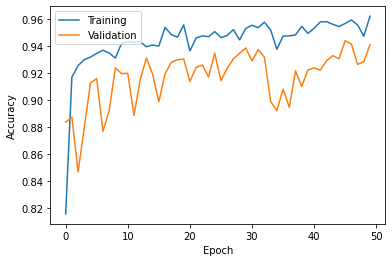

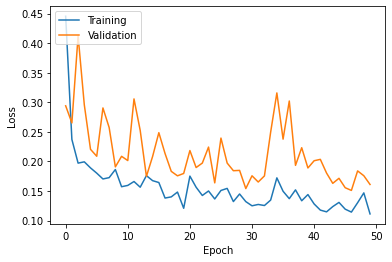

In [ ]:
# Plot accuracy and loss 

## Accuracy
plt.plot(model_unet.history.history['accuracy'])
plt.plot(model_unet.history.history['val_accuracy'])
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper left')
plt.show()

## Loss
plt.plot(model_unet.history.history['loss'])
plt.plot(model_unet.history.history['val_loss'])
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper left')

In [ ]:
# Show model structure
##model_unet.summary()

In [ ]:
# Show picture of model structure
##keras.utils.plot_model(model_unet, show_shapes=True, show_layer_names=True)

## Attention U-Net

In [ ]:
# Train Attention U-Net with generator
model_attention_unet = UNetAM(lr=0.0001)
save_model_am = ModelCheckpoint('unet-attention-3d.hdf5', monitor='val_accuracy',verbose=1, save_best_only=True)
train = trainGenerator(1, t_images, t_masks, data_gen_args, save_to_dir=None)
model_attention_unet.fit(train, steps_per_epoch=100, epochs=50, validation_data = validation_df, callbacks=[save_model_am])

Epoch 1/50
100/100 [==============================] - 17s 130ms/step - loss: 0.5922 - accuracy: 0.6711 - mse: 0.2037 - val_loss: 0.4669 - val_accuracy: 0.7248 - val_mse: 0.1629

Epoch 00001: val_accuracy improved from -inf to 0.72476, saving model to unet-am.hdf5


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/50
100/100 [==============================] - 11s 115ms/step - loss: 0.3155 - accuracy: 0.8892 - mse: 0.0977 - val_loss: 0.2570 - val_accuracy: 0.8816 - val_mse: 0.0805

Epoch 00002: val_accuracy improved from 0.72476 to 0.88164, saving model to unet-am.hdf5
Epoch 3/50
100/100 [==============================] - 11s 115ms/step - loss: 0.1936 - accuracy: 0.9214 - mse: 0.0568 - val_loss: 0.3149 - val_accuracy: 0.8651 - val_mse: 0.0956

Epoch 00003: val_accuracy did not improve from 0.88164
Epoch 4/50
100/100 [==============================] - 12s 115ms/step - loss: 0.1930 - accuracy: 0.9305 - mse: 0.0538 - val_loss: 0.3222 - val_accuracy: 0.8836 - val_mse: 0.0922

Epoch 00004: val_accuracy improved from 0.88164 to 0.88363, saving model to unet-am.hdf5
Epoch 5/50
100/100 [==============================] - 11s 115ms/step - loss: 0.1897 - accuracy: 0.9349 - mse: 0.0520 - val_loss: 0.2188 - val_accuracy: 0.9213 - val_mse: 0.0627

Epoch 00005: val_accuracy improved from 0.88363 to 0.92

In [ ]:
# Save model history
np.save('unet-attention-3d-history.npy',model_attention_unet.history.history)

# Train on 4-band data

## Train on 4-band Amazon data

### U-Net

In [ ]:
# Train U-Net with generator
model_unet_4band = UNet()
save_model_4band = ModelCheckpoint('unet-4d.hdf5', monitor='val_accuracy',verbose=1, save_best_only=True)
model_unet_4band.fit(train_df_4band_amazon, epochs = 20, validation_data = validation_df_4band_amazon, callbacks=[save_model_4band])

Epoch 1/20
250/250 [==============================] - 41s 152ms/step - loss: 0.5126 - accuracy: 0.7480 - mse: 0.1715 - val_loss: 0.3028 - val_accuracy: 0.8949 - val_mse: 0.0911

Epoch 00001: val_accuracy improved from -inf to 0.89490, saving model to unet-4d.hdf5
Epoch 2/20
250/250 [==============================] - 37s 148ms/step - loss: 0.2514 - accuracy: 0.9103 - mse: 0.0727 - val_loss: 0.1978 - val_accuracy: 0.9339 - val_mse: 0.0550

Epoch 00002: val_accuracy improved from 0.89490 to 0.93394, saving model to unet-4d.hdf5
Epoch 3/20
250/250 [==============================] - 37s 148ms/step - loss: 0.2007 - accuracy: 0.9281 - mse: 0.0567 - val_loss: 0.1773 - val_accuracy: 0.9414 - val_mse: 0.0480

Epoch 00003: val_accuracy improved from 0.93394 to 0.94141, saving model to unet-4d.hdf5
Epoch 4/20
250/250 [==============================] - 37s 148ms/step - loss: 0.1702 - accuracy: 0.9399 - mse: 0.0473 - val_loss: 0.1481 - val_accuracy: 0.9487 - val_mse: 0.0402

Epoch 00004: val_accurac

In [ ]:
# Save model history
np.save('unet-4d-history.npy',model_unet_4band.history.history)

### Attention U-Net

In [ ]:
# Train U-Net with generator
model_attention_unet_4band = UNetAM(input_size=(512,512,4))
save_model_4band_attention = ModelCheckpoint('unet-attention-4d.hdf5', monitor='val_accuracy',verbose=1, save_best_only=True)
model_attention_unet_4band.fit(train_df_4band_amazon, epochs = 20, validation_data = validation_df_4band_amazon, callbacks=[save_model_4band_attention])

Epoch 1/20
250/250 [==============================] - 37s 133ms/step - loss: 0.4408 - accuracy: 0.8001 - mse: 0.1443 - val_loss: 0.3109 - val_accuracy: 0.8974 - val_mse: 0.0930

Epoch 00001: val_accuracy improved from -inf to 0.89740, saving model to unet-attention-4d.hdf5


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/20
250/250 [==============================] - 31s 125ms/step - loss: 0.2605 - accuracy: 0.9087 - mse: 0.0759 - val_loss: 0.2060 - val_accuracy: 0.9283 - val_mse: 0.0585

Epoch 00002: val_accuracy improved from 0.89740 to 0.92830, saving model to unet-attention-4d.hdf5
Epoch 3/20
250/250 [==============================] - 31s 125ms/step - loss: 0.2041 - accuracy: 0.9257 - mse: 0.0583 - val_loss: 0.1533 - val_accuracy: 0.9471 - val_mse: 0.0423

Epoch 00003: val_accuracy improved from 0.92830 to 0.94707, saving model to unet-attention-4d.hdf5
Epoch 4/20
250/250 [==============================] - 31s 125ms/step - loss: 0.1745 - accuracy: 0.9360 - mse: 0.0493 - val_loss: 0.1957 - val_accuracy: 0.9210 - val_mse: 0.0586

Epoch 00004: val_accuracy did not improve from 0.94707
Epoch 5/20
250/250 [==============================] - 31s 125ms/step - loss: 0.1581 - accuracy: 0.9403 - mse: 0.0451 - val_loss: 0.1275 - val_accuracy: 0.9551 - val_mse: 0.0348

Epoch 00005: val_accuracy improved 

In [ ]:
# Save model history
np.save('unet-attention-4d-history.npy',model_attention_unet_4band.history.history)

## Train on 4-band Atlantic data

### U-Net

In [ ]:
# Train U-Net with generator
model_unet_4band_atlantic = UNet()
save_model_4band_atlantic = ModelCheckpoint('unet-4d-atlantic.hdf5', monitor='val_accuracy',verbose=1, save_best_only=True)
model_unet_4band_atlantic.fit(train_df_4band_atlantic, epochs = 20, validation_data = validation_df_4band_atlantic, callbacks=[save_model_4band_atlantic])

Epoch 1/20
250/250 [==============================] - 37s 105ms/step - loss: 0.5388 - accuracy: 0.7212 - mse: 0.1838 - val_loss: 0.3309 - val_accuracy: 0.8639 - val_mse: 0.1056

Epoch 00001: val_accuracy improved from -inf to 0.86386, saving model to unet-4d-atlantic.hdf5
Epoch 2/20
250/250 [==============================] - 27s 108ms/step - loss: 0.3442 - accuracy: 0.8550 - mse: 0.1115 - val_loss: 0.3046 - val_accuracy: 0.8780 - val_mse: 0.0955

Epoch 00002: val_accuracy improved from 0.86386 to 0.87801, saving model to unet-4d-atlantic.hdf5
Epoch 3/20
250/250 [==============================] - 27s 110ms/step - loss: 0.3189 - accuracy: 0.8660 - mse: 0.1023 - val_loss: 0.2904 - val_accuracy: 0.8812 - val_mse: 0.0906

Epoch 00003: val_accuracy improved from 0.87801 to 0.88121, saving model to unet-4d-atlantic.hdf5
Epoch 4/20
250/250 [==============================] - 27s 110ms/step - loss: 0.3132 - accuracy: 0.8667 - mse: 0.1007 - val_loss: 0.2809 - val_accuracy: 0.8839 - val_mse: 0.087

In [ ]:
# Save model history
np.save('unet-4d-atlantic-history.npy',model_unet_4band_atlantic.history.history)

### Attention U-Net

In [ ]:
# Train U-Net with generator
model_attention_unet_4band_atlantic = UNetAM(input_size=(512,512,4))
save_model_4band_attention_atlantic = ModelCheckpoint('unet-attention-4d-atlantic.hdf5', monitor='val_accuracy',verbose=1, save_best_only=True)
model_attention_unet_4band_atlantic.fit(train_df_4band_atlantic, epochs = 20, validation_data = validation_df_4band_atlantic, callbacks=[save_model_4band_attention_atlantic])

Epoch 1/20
250/250 [==============================] - 25s 82ms/step - loss: 0.4784 - accuracy: 0.7512 - mse: 0.1610 - val_loss: 0.3479 - val_accuracy: 0.8540 - val_mse: 0.1098

Epoch 00001: val_accuracy improved from -inf to 0.85404, saving model to unet-attention-4d-atlantic.hdf5


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/20
250/250 [==============================] - 19s 75ms/step - loss: 0.3455 - accuracy: 0.8524 - mse: 0.1123 - val_loss: 0.3129 - val_accuracy: 0.8722 - val_mse: 0.0984

Epoch 00002: val_accuracy improved from 0.85404 to 0.87220, saving model to unet-attention-4d-atlantic.hdf5
Epoch 3/20
250/250 [==============================] - 19s 76ms/step - loss: 0.3296 - accuracy: 0.8615 - mse: 0.1059 - val_loss: 0.2860 - val_accuracy: 0.8840 - val_mse: 0.0889

Epoch 00003: val_accuracy improved from 0.87220 to 0.88398, saving model to unet-attention-4d-atlantic.hdf5
Epoch 4/20
250/250 [==============================] - 19s 76ms/step - loss: 0.2948 - accuracy: 0.8724 - mse: 0.0936 - val_loss: 0.2653 - val_accuracy: 0.8872 - val_mse: 0.0821

Epoch 00004: val_accuracy improved from 0.88398 to 0.88722, saving model to unet-attention-4d-atlantic.hdf5
Epoch 5/20
250/250 [==============================] - 19s 76ms/step - loss: 0.2702 - accuracy: 0.8815 - mse: 0.0851 - val_loss: 0.2519 - val_accu

In [ ]:
# Save model history
np.save('unet-attention-4d-atlantic-history.npy',model_unet_4band_atlantic.history.history)

# Plot validation image, with mask, and reconstructions

<Figure size 432x288 with 0 Axes>

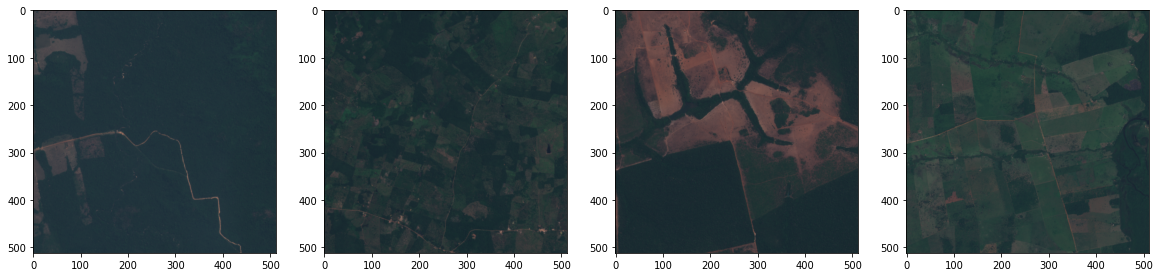

In [ ]:
# Plot a selection of validation set images
plt.figure()
fig, ax = plt.subplots(1,4, figsize=(20,10)) 
ax[0].imshow(validation_images[1].reshape(512,512,3))
ax[1].imshow(validation_images[2].reshape(512,512,3))
ax[2].imshow(validation_images[3].reshape(512,512,3))
ax[3].imshow(validation_images[4].reshape(512,512,3))

<Figure size 432x288 with 0 Axes>

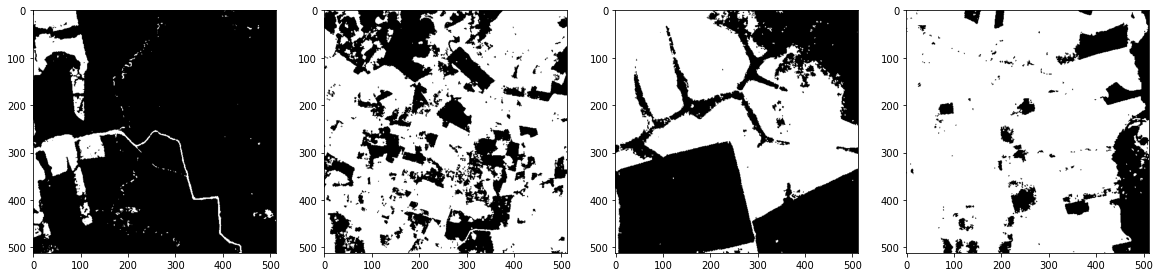

In [ ]:
# Plot corresponding validation set masks
plt.figure()
fig, ax = plt.subplots(1,4, figsize=(20,10)) 
ax[0].imshow(validation_masks[1].reshape(512,512), cmap='gray')
ax[1].imshow(validation_masks[2].reshape(512,512), cmap='gray')
ax[2].imshow(validation_masks[3].reshape(512,512), cmap='gray')
ax[3].imshow(validation_masks[4].reshape(512,512), cmap='gray')

<Figure size 432x288 with 0 Axes>

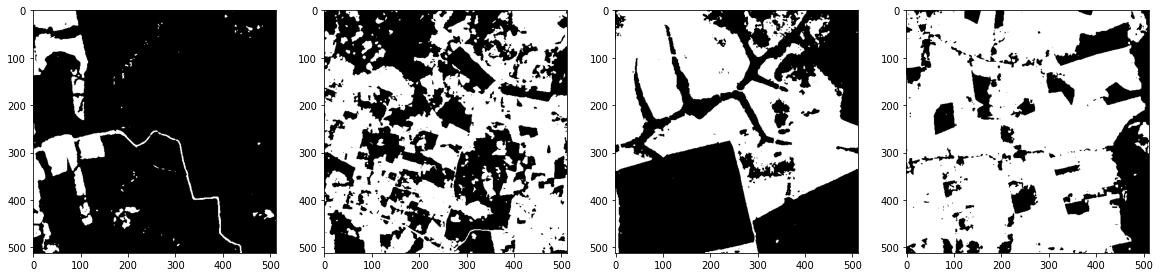

In [ ]:
# Plot reconstructions/predictions of masks for corresponding validation set images (rounded)
plt.figure()
fig, ax = plt.subplots(1,4, figsize=(20,10)) 
ax[0].imshow(reconstruct_array(model_unet, validation_images[1], rounded=True), cmap='gray')
ax[1].imshow(reconstruct_array(model_unet, validation_images[2], rounded=True), cmap='gray')
ax[2].imshow(reconstruct_array(model_unet, validation_images[3], rounded=True), cmap='gray')
ax[3].imshow(reconstruct_array(model_unet, validation_images[4], rounded=True), cmap='gray')

<Figure size 432x288 with 0 Axes>

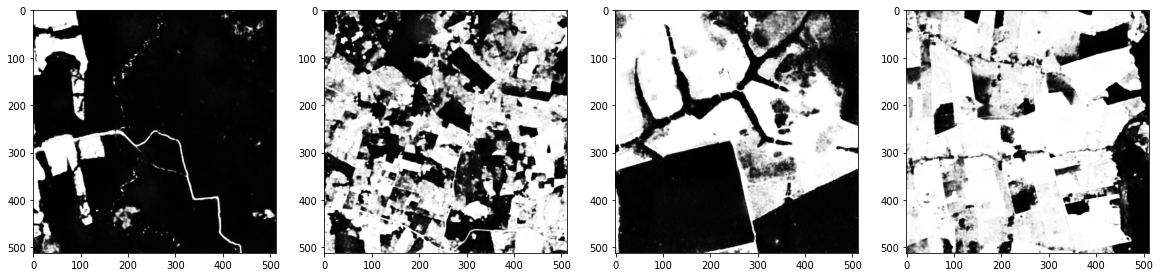

In [ ]:
# Plot reconstructions/predictions of masks for corresponding validation set images (not rounded)
plt.figure()
fig, ax = plt.subplots(1,4, figsize=(20,10)) 
ax[0].imshow(reconstruct_array(model_unet, validation_images[1], rounded=False), cmap='gray')
ax[1].imshow(reconstruct_array(model_unet, validation_images[2], rounded=False), cmap='gray')
ax[2].imshow(reconstruct_array(model_unet, validation_images[3], rounded=False), cmap='gray')
ax[3].imshow(reconstruct_array(model_unet, validation_images[4], rounded=False), cmap='gray')

# Plot test images and reconstructions

<Figure size 432x288 with 0 Axes>

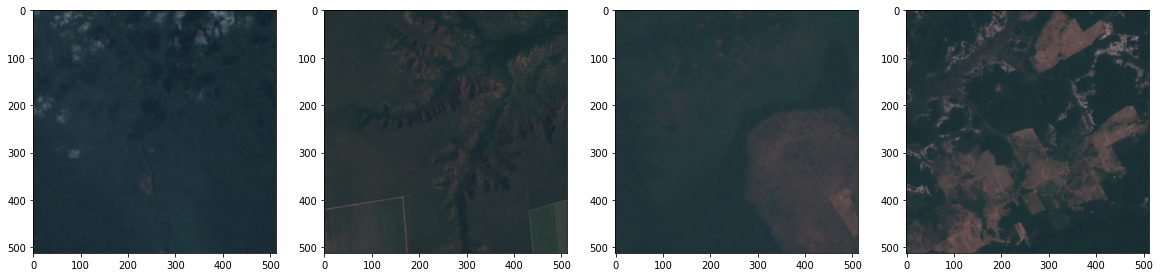

In [ ]:
# Plot a selection of test set images
plt.figure()
fig, ax = plt.subplots(1,4, figsize=(20,10)) 
ax[0].imshow(test_images[1].reshape(512,512,3))
ax[1].imshow(test_images[2].reshape(512,512,3))
ax[2].imshow(test_images[3].reshape(512,512,3))
ax[3].imshow(test_images[4].reshape(512,512,3))

<Figure size 432x288 with 0 Axes>

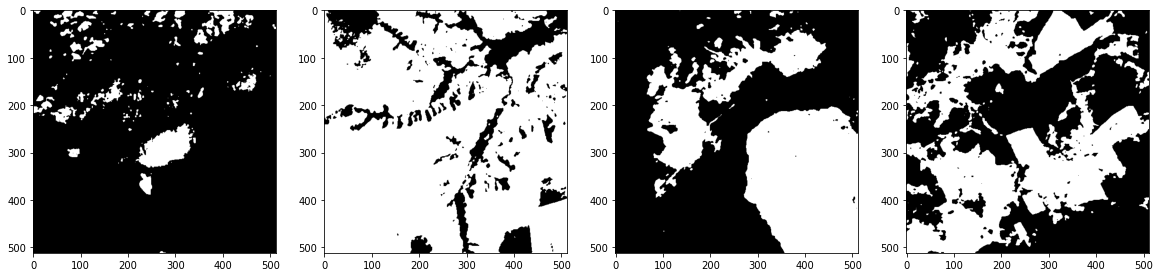

In [ ]:
# Plot corresponding reconstructions/predictions (rounded)
plt.figure()
fig, ax = plt.subplots(1,4, figsize=(20,10)) 
ax[0].imshow(reconstruct_array(model, test_images[1], rounded=True), cmap='gray')
ax[1].imshow(reconstruct_array(model, test_images[2], rounded=True), cmap='gray')
ax[2].imshow(reconstruct_array(model, test_images[3], rounded=True), cmap='gray')
ax[3].imshow(reconstruct_array(model, test_images[4], rounded=True), cmap='gray')

<Figure size 432x288 with 0 Axes>

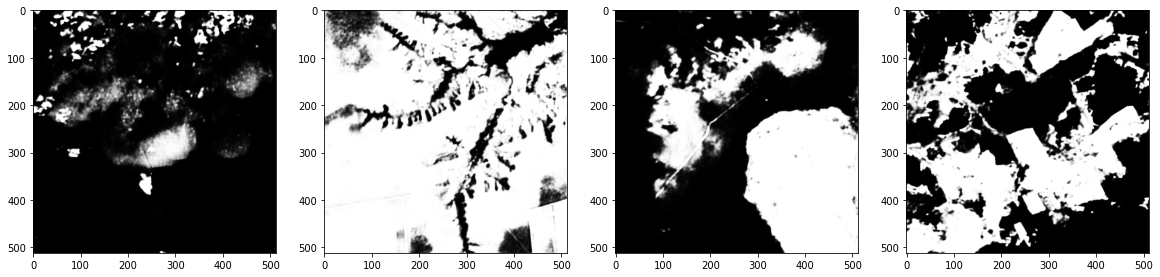

In [ ]:
# Plot corresponding reconstructions/predictions (not rounded)
plt.figure()
fig, ax = plt.subplots(1,4, figsize=(20,10)) 
ax[0].imshow(reconstruct_array(model, test_images[1]), cmap='gray')
ax[1].imshow(reconstruct_array(model, test_images[2]), cmap='gray')
ax[2].imshow(reconstruct_array(model, test_images[3]), cmap='gray')
ax[3].imshow(reconstruct_array(model, test_images[4]), cmap='gray')

# ResNet50-SegNet

**Links to review**

https://arxiv.org/abs/1512.03385 -- ResNet paper

https://arxiv.org/pdf/1511.00561.pdf -- SegNet paper

https://github.com/qubvel/classification_models/blob/master/classification_models/models/resnet.py   -- ResNet50 encoder

https://github.com/preddy5/segnet/blob/master/segnet.py -- SegNet zero padding

https://github.com/priya-dwivedi/Deep-Learning/blob/master/resnet_keras/Residual_Networks_yourself.ipynb -- Example code

https://www.semanticscholar.org/paper/Drone-Image-Segmentation-Using-Machine-and-Deep-for-Bhatnagar-Gill/d53b459683f9fdef549b8bb425203410ba235384 -- RESNET50-SEGNET

## Model

In [ ]:
def resnetConvDownBlock(x, filter, kernel, act='relu'):
  # Convolutional Block for encoding phase
  for i in range(3):
    x = ZeroPadding2D((1,1))(x)
    x = Conv2D(filters = filter, kernel_size = kernel, kernel_initializer = 'he_normal')(x)
    x = Activation('relu')(x)
    
  return x

def resnetConvUpBlock(x, skip_connection = None, filter = None, kernel = None, act='relu'):
  # Convolutional block for decoding phase
  
  out = x

  # Unpooling
  out = UpSampling2D((2,2))(out)
  #out = Conv2DTranspose(filters = filter, kernel_size = kernel, kernel_initializer = 'he_normal')(out)

  # Conv Block
  for i in range(3):
    out = ZeroPadding2D((1,1))(out)
    out = Conv2D(filters = filter, kernel_size = kernel, kernel_initializer = 'he_normal')(out)
    out = Activation('relu')(out)

  # Implement skip connection
  if skip_connection != None:
    out = Add()([out, skip_connection])

  return out

def ResNet50SegNet(input_size=(512,512,3), lr = 0.0001, filters = 64, kernel_sz = 3):

  inputs = Input(input_size)

  # Encoder
  # Conv, Conv, Conv, MaxPool #1
  block1 = resnetConvDownBlock(inputs, filter = filters, kernel = kernel_sz)
  pool1 = MaxPooling2D((2,2))(block1)
  # Conv, Conv, Conv, MaxPool #2
  block2 = resnetConvDownBlock(pool1, filter = 2 * filters, kernel = kernel_sz)
  pool2 = MaxPooling2D((2,2))(block2)
  # Conv, Conv, Conv, MaxPool #3
  block3 = resnetConvDownBlock(pool2, filter = 4 * filters, kernel = kernel_sz)
  pool3 = MaxPooling2D((2,2))(block3)
  # Conv, Conv, Conv, MaxPool #4
  block4 = resnetConvDownBlock(pool3, filter = 8 * filters, kernel = kernel_sz)
  pool4 = MaxPooling2D((2,2))(block4)
  # Conv, Conv, Conv, MaxPool #5
  block5 = resnetConvDownBlock(pool4, filter = 16 * filters, kernel = kernel_sz)
  pool5 = MaxPooling2D((2,2))(block5)

  # Decoder
  # ConvTranspose + Concat, Conv, Conv, Conv #1
  block5_ = resnetConvUpBlock(pool5, filter = 16 * filters, kernel = kernel_sz)
  # ConvTranspose + Concat, Conv, Conv, Conv #2
  block4_ = resnetConvUpBlock(block5_, skip_connection = block4, filter = 8 * filters, kernel = kernel_sz)
  # ConvTranspose + Concat, Conv, Conv, Conv #3
  block3_ = resnetConvUpBlock(block4_, skip_connection = block3, filter = 4 * filters, kernel = kernel_sz)
  # ConvTranspose + Concat, Conv, Conv, Conv #4
  block2_ = resnetConvUpBlock(block3_, skip_connection = block2, filter = 2 * filters, kernel = kernel_sz)
  # ConvTranspose + Concat, Conv, Conv, Conv #5
  block1_ = resnetConvUpBlock(block2_, skip_connection = block1, filter = filters, kernel = kernel_sz)
  # Output
  outputs = Conv2D(1, kernel_size = 1, strides = 1, kernel_initializer = 'he_normal')(block1_)
  outputs = Activation('sigmoid')(outputs)

  model = Model(inputs, outputs)
  model.compile(optimizer = Adam(learning_rate = lr), loss = binary_crossentropy, metrics = ['accuracy', 'mse'])

  return model

In [ ]:
ResNet50SegNet().summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 512, 512, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 514, 514, 3)  0           input_3[0][0]                    
__________________________________________________________________________________________________
conv2d_50 (Conv2D)              (None, 512, 512, 64) 1792        zero_padding2d[0][0]             
__________________________________________________________________________________________________
activation_46 (Activation)      (None, 512, 512, 64) 0           conv2d_50[0][0]                  
____________________________________________________________________________________________

## Train on RGB feature data

In [ ]:
R = ResNet50SegNet()
save_model_resnet = ModelCheckpoint('resnet50segnet-3d.hdf5', monitor='val_accuracy',verbose=1, save_best_only=True)
train = trainGenerator(1, t_images, t_masks, data_gen_args, save_to_dir=None)
R.fit(train, validation_data = validation_df, epochs = 50, steps_per_epoch = 100, callbacks=[save_model_resnet])

Epoch 1/50
100/100 [==============================] - 19s 143ms/step - loss: 0.8548 - accuracy: 0.6763 - mse: 0.1890 - val_loss: 0.3243 - val_accuracy: 0.8740 - val_mse: 0.0965

Epoch 00001: val_accuracy improved from -inf to 0.87404, saving model to resnet50segnet-3d.hdf5


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/50
100/100 [==============================] - 13s 127ms/step - loss: 0.2137 - accuracy: 0.9288 - mse: 0.0571 - val_loss: 0.2807 - val_accuracy: 0.8859 - val_mse: 0.0856

Epoch 00002: val_accuracy improved from 0.87404 to 0.88591, saving model to resnet50segnet-3d.hdf5
Epoch 3/50
100/100 [==============================] - 13s 126ms/step - loss: 0.1903 - accuracy: 0.9327 - mse: 0.0529 - val_loss: 0.2035 - val_accuracy: 0.9218 - val_mse: 0.0593

Epoch 00003: val_accuracy improved from 0.88591 to 0.92178, saving model to resnet50segnet-3d.hdf5
Epoch 4/50
100/100 [==============================] - 13s 126ms/step - loss: 0.2173 - accuracy: 0.9360 - mse: 0.0530 - val_loss: 0.2146 - val_accuracy: 0.9220 - val_mse: 0.0608

Epoch 00004: val_accuracy improved from 0.92178 to 0.92204, saving model to resnet50segnet-3d.hdf5
Epoch 5/50
100/100 [==============================] - 13s 126ms/step - loss: 0.1675 - accuracy: 0.9439 - mse: 0.0444 - val_loss: 0.2258 - val_accuracy: 0.9125 - val_mse:

In [ ]:
# Save model history
np.save('resnet50segnet-3d-history.npy',R.history.history)

## Train on 4-band data

### Train on 4-band Amazon data

In [ ]:
R_4band = ResNet50SegNet(input_size=(512,512,4))
save_model_resnet_4band = ModelCheckpoint('resnet50segnet-4d.hdf5', monitor='val_accuracy',verbose=1, save_best_only=True)
R_4band.fit(train_df_4band_amazon, validation_data = validation_df_4band_amazon, epochs = 20, callbacks=[save_model_resnet_4band])

Epoch 1/20
250/250 [==============================] - 40s 139ms/step - loss: 0.5424 - accuracy: 0.8156 - mse: 0.1462 - val_loss: 0.2498 - val_accuracy: 0.9010 - val_mse: 0.0736

Epoch 00001: val_accuracy improved from -inf to 0.90104, saving model to resnet50segnet-4d.hdf5


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/20
250/250 [==============================] - 33s 133ms/step - loss: 0.2646 - accuracy: 0.8910 - mse: 0.0794 - val_loss: 0.1510 - val_accuracy: 0.9434 - val_mse: 0.0434

Epoch 00002: val_accuracy improved from 0.90104 to 0.94339, saving model to resnet50segnet-4d.hdf5
Epoch 3/20
250/250 [==============================] - 33s 133ms/step - loss: 0.1665 - accuracy: 0.9341 - mse: 0.0490 - val_loss: 0.1246 - val_accuracy: 0.9518 - val_mse: 0.0361

Epoch 00003: val_accuracy improved from 0.94339 to 0.95185, saving model to resnet50segnet-4d.hdf5
Epoch 4/20
250/250 [==============================] - 33s 133ms/step - loss: 0.1469 - accuracy: 0.9425 - mse: 0.0428 - val_loss: 0.1111 - val_accuracy: 0.9581 - val_mse: 0.0318

Epoch 00004: val_accuracy improved from 0.95185 to 0.95813, saving model to resnet50segnet-4d.hdf5
Epoch 5/20
250/250 [==============================] - 33s 133ms/step - loss: 0.1251 - accuracy: 0.9511 - mse: 0.0363 - val_loss: 0.0993 - val_accuracy: 0.9626 - val_mse:

In [ ]:
# Save model history
np.save('resnet50segnet-4d-history.npy', R_4band.history.history)

### Train on 4-band Atlantic data

In [ ]:
R_4band_atlantic = ResNet50SegNet(input_size=(512,512,4))
save_model_resnet_4band_atlantic = ModelCheckpoint('resnet50segnet-4d-atlantic.hdf5', monitor='val_accuracy',verbose=1, save_best_only=True)
R_4band_atlantic.fit(train_df_4band_atlantic, validation_data = validation_df_4band_atlantic, epochs = 20, callbacks=[save_model_resnet_4band_atlantic])

Epoch 1/20
250/250 [==============================] - 41s 146ms/step - loss: 0.5345 - accuracy: 0.7489 - mse: 0.1701 - val_loss: 0.3378 - val_accuracy: 0.8585 - val_mse: 0.1052

Epoch 00001: val_accuracy improved from -inf to 0.85850, saving model to resnet50segnet-4d-atlantic.hdf5


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/20
250/250 [==============================] - 40s 158ms/step - loss: 0.3315 - accuracy: 0.8568 - mse: 0.1066 - val_loss: 0.2964 - val_accuracy: 0.8770 - val_mse: 0.0922

Epoch 00002: val_accuracy improved from 0.85850 to 0.87701, saving model to resnet50segnet-4d-atlantic.hdf5
Epoch 3/20
250/250 [==============================] - 39s 158ms/step - loss: 0.3142 - accuracy: 0.8655 - mse: 0.1003 - val_loss: 0.2844 - val_accuracy: 0.8833 - val_mse: 0.0880

Epoch 00003: val_accuracy improved from 0.87701 to 0.88334, saving model to resnet50segnet-4d-atlantic.hdf5
Epoch 4/20
250/250 [==============================] - 34s 136ms/step - loss: 0.3014 - accuracy: 0.8680 - mse: 0.0959 - val_loss: 0.2686 - val_accuracy: 0.8875 - val_mse: 0.0823

Epoch 00004: val_accuracy improved from 0.88334 to 0.88752, saving model to resnet50segnet-4d-atlantic.hdf5
Epoch 5/20
250/250 [==============================] - 33s 132ms/step - loss: 0.2791 - accuracy: 0.8729 - mse: 0.0886 - val_loss: 0.2653 - val_

In [ ]:
# Save model history
np.save('resnet50segnet-4d-history-atlantic.npy', R_4band_atlantic.history.history)

# FCN32-VGG16

https://arxiv.org/pdf/1605.06211.pdf -- Original paper

https://github.com/divamgupta/image-segmentation-keras -- Forked code for FCN32

## Model

In [ ]:
def fcn_32(input_size = (512,512,3), lr = 0.0001, drop_rate = 0):
  
    kernel = 3
    filter_size = 64
    pad = 1
    pool_size = 2

    IMAGE_ORDERING = 'channels_last'
    inputs = Input(shape=input_size)

    x = inputs
    levels = []

    x = Conv2D(64, (3, 3), padding='same',
               name='block1_conv1', data_format=IMAGE_ORDERING)(inputs)
    x = Activation('relu')(x)
    x = Conv2D(64, (3, 3), padding='same',
               name='block1_conv2', data_format=IMAGE_ORDERING)(x)
    x = Activation('relu')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block1_pool',
                     data_format=IMAGE_ORDERING)(x)
    levels.append(x)

    # Block 2
    x = Conv2D(128, (3, 3), padding='same',
               name='block2_conv1', data_format=IMAGE_ORDERING)(x)
    x = Activation('relu')(x)
    x = Conv2D(128, (3, 3), padding='same',
               name='block2_conv2', data_format=IMAGE_ORDERING)(x)
    x = Activation('relu')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block2_pool',
                     data_format=IMAGE_ORDERING)(x)
    levels.append(x)

    # Block 3
    x = Conv2D(256, (3, 3), padding='same',
               name='block3_conv1', data_format=IMAGE_ORDERING)(x)
    x = Activation('relu')(x)
    x = Conv2D(256, (3, 3), padding='same',
               name='block3_conv2', data_format=IMAGE_ORDERING)(x)
    x = Activation('relu')(x)
    x = Conv2D(256, (3, 3), padding='same',
               name='block3_conv3', data_format=IMAGE_ORDERING)(x)
    x = Activation('relu')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block3_pool',
                     data_format=IMAGE_ORDERING)(x)
    levels.append(x)

    # Block 4
    x = Conv2D(512, (3, 3), padding='same',
               name='block4_conv1', data_format=IMAGE_ORDERING)(x)
    x = Activation('relu')(x)
    x = Conv2D(512, (3, 3), padding='same',
               name='block4_conv2', data_format=IMAGE_ORDERING)(x)
    x = Activation('relu')(x)
    x = Conv2D(512, (3, 3), padding='same',
               name='block4_conv3', data_format=IMAGE_ORDERING)(x)
    x = Activation('relu')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block4_pool',
                     data_format=IMAGE_ORDERING)(x)
    levels.append(x)

    # Block 5
    x = Conv2D(512, (3, 3), padding='same',
               name='block5_conv1', data_format=IMAGE_ORDERING)(x)
    x = Activation('relu')(x)
    x = Conv2D(512, (3, 3), padding='same',
               name='block5_conv2', data_format=IMAGE_ORDERING)(x)
    x = Activation('relu')(x)
    x = Conv2D(512, (3, 3), padding='same',
               name='block5_conv3', data_format=IMAGE_ORDERING)(x)
    x = Activation('relu')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block5_pool',
                     data_format=IMAGE_ORDERING)(x)

    levels.append(x)

    [f1, f2, f3, f4, f5] = levels

    o = f5

    o = (Conv2D(4096, (7 , 7 ), padding = 'same', kernel_initializer = 'he_normal', name = "conv6"))(o)
    o = Activation('relu')(o)
    o = Dropout(drop_rate)(o)
    o = (Conv2D(4096, (1 , 1 ), padding = 'same', kernel_initializer = 'he_normal', name = "conv7"))(o)
    o = Activation('relu')(o)
    o = Dropout(drop_rate)(o)

    o = (Conv2D(1, 1, padding='same', kernel_initializer='he_normal', name="scorer1"))(o)
    o = Conv2DTranspose(1, kernel_size=(64,64), padding='same', strides=(32,32), name="Upsample32")(o)


    #o = Conv2D(1,1,1)(o)
    o = Activation('sigmoid')(o)

    model = Model(inputs, o)
    model.compile(optimizer = Adam(learning_rate = lr), loss = binary_crossentropy, metrics = ['accuracy', 'mse'])
    model.model_name = "fcn_32"
    return model

In [ ]:
fcn_32().summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 512, 512, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 512, 512, 64)      1792      
_________________________________________________________________
activation_77 (Activation)   (None, 512, 512, 64)      0         
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 512, 512, 64)      36928     
_________________________________________________________________
activation_78 (Activation)   (None, 512, 512, 64)      0         
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 256, 256, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 256, 256, 128)     7385

## Train on RGB feature data

In [ ]:
F = fcn_32(lr = 0.0001)
save_model_fcn32 = ModelCheckpoint('fcn32-3d.hdf5', monitor='val_accuracy',verbose=1, save_best_only=True)
train = trainGenerator(1, t_images, t_masks, data_gen_args, save_to_dir=None)
F.fit(train, validation_data = validation_df, epochs=70, steps_per_epoch = 100, shuffle = True, callbacks=[save_model_fcn32])

Epoch 1/70
100/100 [==============================] - 48s 181ms/step - loss: 0.6931 - accuracy: 0.5284 - mse: 0.2500 - val_loss: 0.6929 - val_accuracy: 0.5296 - val_mse: 0.2499

Epoch 00001: val_accuracy improved from -inf to 0.52965, saving model to fcn32-3d.hdf5
Epoch 2/70
100/100 [==============================] - 17s 172ms/step - loss: 0.6929 - accuracy: 0.5227 - mse: 0.2499 - val_loss: 0.6930 - val_accuracy: 0.4619 - val_mse: 0.2500

Epoch 00002: val_accuracy did not improve from 0.52965
Epoch 3/70
100/100 [==============================] - 17s 171ms/step - loss: 0.6680 - accuracy: 0.5484 - mse: 0.2366 - val_loss: 0.8077 - val_accuracy: 0.7401 - val_mse: 0.2042

Epoch 00003: val_accuracy improved from 0.52965 to 0.74013, saving model to fcn32-3d.hdf5
Epoch 4/70
100/100 [==============================] - 17s 171ms/step - loss: 0.4919 - accuracy: 0.7955 - mse: 0.1532 - val_loss: 0.4509 - val_accuracy: 0.7911 - val_mse: 0.1468

Epoch 00004: val_accuracy improved from 0.74013 to 0.791

In [ ]:
# Save model history
np.save('fcn32-3d-history.npy', F.history.history)

In [ ]:
# Save weights (model save itself is > 1.5GB)
load_model('fcn32-3d.hdf5').save_weights('fcn32-3d-weights.h5')

## Train on 4-band data

### Train on 4-band Amazon data

In [ ]:
F_4band = fcn_32(input_size=(512,512,4), lr = 0.0001)
save_model_fcn_4band = ModelCheckpoint('fcn32-4d.hdf5', monitor='val_accuracy',verbose=1, save_best_only=True)
F_4band.fit(train_df_4band_amazon, validation_data = validation_df_4band_amazon, epochs = 30, callbacks=[save_model_fcn_4band])

Epoch 1/30
250/250 [==============================] - 49s 187ms/step - loss: 0.6932 - accuracy: 0.4953 - mse: 0.2500 - val_loss: 0.6925 - val_accuracy: 0.5768 - val_mse: 0.2497

Epoch 00001: val_accuracy improved from -inf to 0.57682, saving model to fcn32-4d.hdf5
Epoch 2/30
250/250 [==============================] - 46s 183ms/step - loss: 0.6945 - accuracy: 0.5268 - mse: 0.2498 - val_loss: 0.6516 - val_accuracy: 0.6342 - val_mse: 0.2229

Epoch 00002: val_accuracy improved from 0.57682 to 0.63419, saving model to fcn32-4d.hdf5
Epoch 3/30
250/250 [==============================] - 46s 183ms/step - loss: 0.6619 - accuracy: 0.5824 - mse: 0.2339 - val_loss: 0.4353 - val_accuracy: 0.8106 - val_mse: 0.1391

Epoch 00003: val_accuracy improved from 0.63419 to 0.81064, saving model to fcn32-4d.hdf5
Epoch 4/30
250/250 [==============================] - 46s 183ms/step - loss: 0.4483 - accuracy: 0.8103 - mse: 0.1409 - val_loss: 0.3410 - val_accuracy: 0.8621 - val_mse: 0.1047

Epoch 00004: val_accu

In [ ]:
# Save model history
np.save('fcn32-4d-history.npy', F_4band.history.history)

In [ ]:
# Save weights (model save itself is > 1.5GB)
load_model('fcn32-4d.hdf5').save_weights('fcn32-4d-weights.h5')

### Train on 4-band Atlantic data

In [ ]:
F_4band_atlantic = fcn_32(input_size=(512,512,4), lr = 0.0001)
save_model_fcn32_4band_atlantic = ModelCheckpoint('fcn32-4d-atlantic.hdf5', monitor='val_accuracy',verbose=1, save_best_only=True)
F_4band_atlantic.fit(train_df_4band_atlantic, validation_data = validation_df_4band_atlantic, epochs = 30, callbacks=[save_model_fcn32_4band_atlantic])

Epoch 1/30
250/250 [==============================] - 51s 189ms/step - loss: 0.6861 - accuracy: 0.5916 - mse: 0.2464 - val_loss: 0.6443 - val_accuracy: 0.6550 - val_mse: 0.2260

Epoch 00001: val_accuracy improved from -inf to 0.65502, saving model to fcn32-4d-atlantic.hdf5
Epoch 2/30
250/250 [==============================] - 46s 183ms/step - loss: 0.6380 - accuracy: 0.6584 - mse: 0.2231 - val_loss: 0.6008 - val_accuracy: 0.6581 - val_mse: 0.2072

Epoch 00002: val_accuracy improved from 0.65502 to 0.65810, saving model to fcn32-4d-atlantic.hdf5
Epoch 3/30
250/250 [==============================] - 46s 183ms/step - loss: 0.5952 - accuracy: 0.6605 - mse: 0.2047 - val_loss: 0.5268 - val_accuracy: 0.7402 - val_mse: 0.1771

Epoch 00003: val_accuracy improved from 0.65810 to 0.74016, saving model to fcn32-4d-atlantic.hdf5
Epoch 4/30
250/250 [==============================] - 46s 183ms/step - loss: 0.5829 - accuracy: 0.6775 - mse: 0.1988 - val_loss: 0.5039 - val_accuracy: 0.7529 - val_mse: 0.

In [ ]:
# Save model history
np.save('fcn32-4d-atlantic-history.npy', F_4band_atlantic.history.history)

In [ ]:
# Save weights (model save itself is > 1.5GB)
load_model('fcn32-4d-atlantic.hdf5').save_weights('fcn32-4d-atlantic-weights.h5')

# Import Models and Compute Metrics

## 3-dim

In [ ]:
# Load 3-dim models and history stats
attention_unet = load_model('unet-attention-3d.hdf5')
unet = load_model('unet-3d.hdf5')

unet_history = np.load('unet-3d-history.npy', allow_pickle='TRUE').item()
attention_unet_history = np.load('unet-attention-3d-history.npy', allow_pickle='TRUE').item()

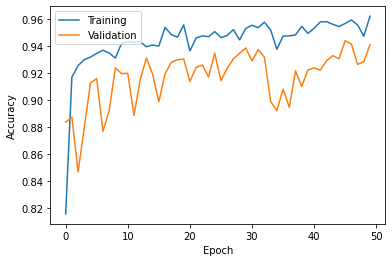

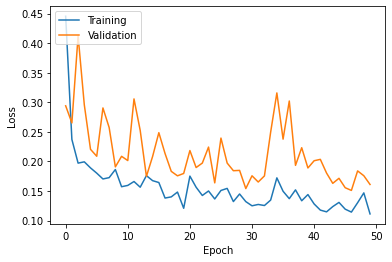

In [ ]:
# Plot accuracy and loss for U-Net

## Accuracy
plt.plot(unet_history['accuracy'])
plt.plot(unet_history['val_accuracy'])
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper left')
plt.show()

## Loss
plt.plot(unet_history['loss'])
plt.plot(unet_history['val_loss'])
plt.ylabel('Loss', size=12)
plt.xlabel('Epoch', size=12)
plt.legend(['Training', 'Validation'], loc='lower right')

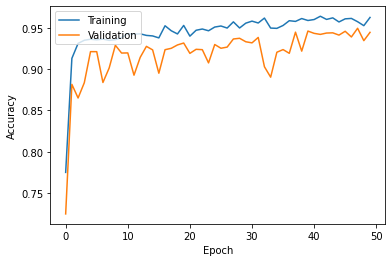

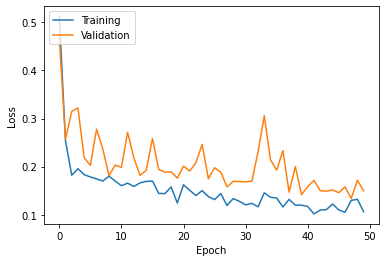

In [ ]:
# Plot accuracy and loss for Attention U-Net

## Accuracy
plt.plot(attention_unet_history['accuracy'])
plt.plot(attention_unet_history['val_accuracy'])
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper left')
plt.show()

## Loss
plt.plot(attention_unet_history['loss'])
plt.plot(attention_unet_history['val_loss'])
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper left')

In [ ]:
# Scores of each model
unet_score = (score_eval(unet, validation_images, validation_masks))
am_unet_score = (score_eval(attention_unet, validation_images, validation_masks))

In [ ]:
# Precision and recall of each model
unet_precision = (precision_eval(unet, validation_images, validation_masks))
am_unet_precision = (precision_eval(attention_unet, validation_images, validation_masks))

unet_recall = (recall_eval(unet, validation_images, validation_masks))
am_unet_recall = (recall_eval(attention_unet, validation_images, validation_masks))

In [ ]:
# F1-scores of each model
unet_f1_score = (f1_score_eval_basic(unet_precision, unet_recall))
am_unet_f1_score = (f1_score_eval_basic(am_unet_precision, am_unet_recall))

In [ ]:
# Print score eval results for each model
print('U-Net accuracy: ', np.mean(unet_score), np.std(unet_score))
print('Attention U-Net accuracy: ', np.mean(am_unet_score), np.std(am_unet_score))

U-Net accuracy:  0.9441879272460938 0.051456469735835106
Attention U-Net accuracy:  0.9495686848958333 0.04148326611753007


In [ ]:
# Print precision eval results for each model
print('U-Net precision: ', np.mean(unet_precision), np.std(unet_precision))
print('Attention U-Net precision: ', np.mean(am_unet_precision), np.std(am_unet_precision))

U-Net precision:  0.9529248154492593 0.038749466829152916
Attention U-Net precision:  0.9547959659777044 0.033681520771207146


In [ ]:
# Print recall eval results for each model
print('U-Net recall: ', np.mean(unet_recall), np.std(unet_recall))
print('Attention U-Net recall: ', np.mean(am_unet_recall), np.std(am_unet_recall))

U-Net recall:  0.9441879272460938 0.051456469735835106
Attention U-Net recall:  0.9495686848958333 0.04148326611753007


In [ ]:
# Print f1-score eval results for each model
print('U-Net F1-score: ', np.mean(unet_f1_score))
print('Attention U-Net F1-score: ', np.mean(am_unet_f1_score))

U-Net F1-score:  0.9485362530875023
Attention U-Net F1-score:  0.9521751512678154


## 4-dim

### Amazon Data

In [ ]:
# Load 4-dim models and history stats
attention_unet_4d = load_model('unet-attention-4d.hdf5')
unet_4d = load_model('unet-4d.hdf5')

unet_4d_history = np.load('unet-4d-history.npy', allow_pickle='TRUE').item()
attention_unet_4d_history = np.load('unet-attention-4d-history.npy', allow_pickle='TRUE').item()

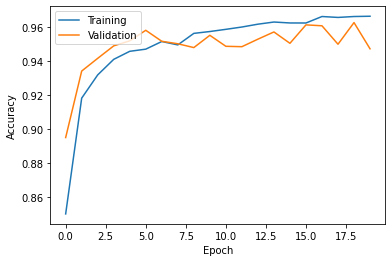

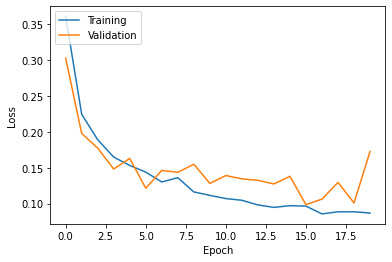

In [ ]:
# Plot accuracy and loss for U-Net

## Accuracy
plt.plot(unet_4d_history['accuracy'])
plt.plot(unet_4d_history['val_accuracy'])
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper left')
plt.show()

## Loss
plt.plot(unet_4d_history['loss'])
plt.plot(unet_4d_history['val_loss'])
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper left')

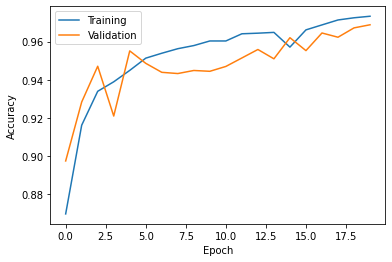

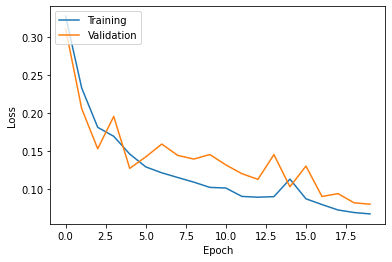

In [ ]:
# Plot accuracy and loss for Attention U-Net

## Accuracy
plt.plot(attention_unet_4d_history['accuracy'])
plt.plot(attention_unet_4d_history['val_accuracy'])
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper left')
plt.show()

## Loss
plt.plot(attention_unet_4d_history['loss'])
plt.plot(attention_unet_4d_history['val_loss'])
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper left')

In [ ]:
# Scores of each model
unet_4d_score = (score_eval2(unet_4d, validation_images2, validation_masks2))
am_unet_4d_score = (score_eval2(attention_unet_4d, validation_images2, validation_masks2))

In [ ]:
# Precision and recall of each model
unet_4d_precision = (precision_eval(unet_4d, validation_images2, validation_masks2))
am_unet_4d_precision = (precision_eval(attention_unet_4d, validation_images2, validation_masks2))

unet_4d_recall = (recall_eval(unet_4d, validation_images2, validation_masks2))
am_unet_4d_recall = (recall_eval(attention_unet_4d, validation_images2, validation_masks2))

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
# F1-scores of each model
unet_4d_f1_score = (f1_score_eval_basic(unet_4d_precision, unet_4d_recall))
am_unet_4d_f1_score = (f1_score_eval_basic(am_unet_4d_precision, am_unet_4d_recall))

In [ ]:
# Print score eval results for each model
print('U-Net accuracy: ', np.mean(unet_4d_score), np.std(unet_4d_score))
print('Attention U-Net accuracy: ', np.mean(am_unet_4d_score), np.std(am_unet_4d_score))

U-Net accuracy:  0.9624031066894532 0.03123559126468278
Attention U-Net accuracy:  0.9688179016113281 0.022514025648120196


In [ ]:
# Print precision eval results for each model
print('U-Net precision: ', np.mean(unet_4d_precision), np.std(unet_4d_precision))
print('Attention U-Net precision: ', np.mean(am_unet_4d_precision), np.std(am_unet_4d_precision))

U-Net precision:  0.9661751857090445 0.026013561497850026
Attention U-Net precision:  0.9719768498331767 0.02004406707922581


In [ ]:
# Print recall eval results for each model
print('U-Net recall: ', np.mean(unet_4d_recall), np.std(unet_4d_recall))
print('Attention U-Net recall: ', np.mean(am_unet_4d_recall), np.std(am_unet_4d_recall))

U-Net recall:  0.9624031066894532 0.03123559126468278
Attention U-Net recall:  0.9688179016113281 0.022514025648120196


In [ ]:
# Print f1-score eval results for each model
print('U-Net F1-score: ', np.mean(unet_4d_f1_score))
print('Attention U-Net F1-score: ', np.mean(am_unet_4d_f1_score))

U-Net F1-score:  0.9642854573212327
Attention U-Net F1-score:  0.9703948048801113


### Amazon on unseen Atlantic data

In [ ]:
# Score
unet_amazon_on_atlantic_score = score_eval2(unet_4d, validation_images3, validation_masks3)
am_unet_amazon_on_atlantic_score = score_eval2(attention_unet_4d, validation_images3, validation_masks3)

# Precision
unet_amazon_on_atlantic_precision = (precision_eval(unet_4d, validation_images3, validation_masks3))
am_unet_amazon_on_atlantic_precision = (precision_eval(attention_unet_4d, validation_images3, validation_masks3))

# Recall
unet_amazon_on_atlantic_recall = (recall_eval(unet_4d, validation_images3, validation_masks3))
am_unet_amazon_on_atlantic_recall = (recall_eval(attention_unet_4d, validation_images3, validation_masks3))

# F1-scores of each model
unet_amazon_on_atlantic_f1_score = (f1_score_eval_basic(unet_amazon_on_atlantic_precision, unet_amazon_on_atlantic_recall))
am_unet_amazon_on_atlantic_f1_score = (f1_score_eval_basic(am_unet_amazon_on_atlantic_precision, am_unet_amazon_on_atlantic_recall))

In [ ]:
# Print metrics
print('U-Net score: ', np.mean(unet_amazon_on_atlantic_score), np.std(unet_amazon_on_atlantic_score))
print('Attention U-Net score: ', np.mean(am_unet_amazon_on_atlantic_score), np.std(am_unet_amazon_on_atlantic_score))

print('U-Net precision: ', np.mean(unet_amazon_on_atlantic_precision), np.std(unet_amazon_on_atlantic_precision))
print('Attention U-Net precision: ', np.mean(am_unet_amazon_on_atlantic_precision), np.std(am_unet_amazon_on_atlantic_precision))

print('U-Net recall: ', np.mean(unet_amazon_on_atlantic_recall), np.std(unet_amazon_on_atlantic_recall))
print('Attention U-Net recall: ', np.mean(am_unet_amazon_on_atlantic_recall), np.std(am_unet_amazon_on_atlantic_recall))

print('U-Net F1-score: ', unet_amazon_on_atlantic_f1_score)
print('Attention U-Net F1-score: ', am_unet_amazon_on_atlantic_f1_score)

U-Net score:  0.8623001098632812 0.09697629059161807
Attention U-Net score:  0.8816988372802734 0.09569811216951518
U-Net precision:  0.893379008287948 0.06937541506332207
Attention U-Net precision:  0.9111291102608063 0.05381396192627414
U-Net recall:  0.8623001098632812 0.09697629059161807
Attention U-Net recall:  0.8816988372802734 0.09569811216951518
U-Net F1-score:  0.877564480925711
Attention U-Net F1-score:  0.8961724165790379


### Atlantic Data

In [ ]:
# Load 4-dim models and history stats
attention_unet_4d_atlantic = load_model('unet-attention-4d-atlantic.hdf5')
unet_4d_atlantic = load_model('unet-4d-atlantic.hdf5')

unet_4d_atlantic_history = np.load('unet-4d-atlantic-history.npy', allow_pickle='TRUE').item()
attention_unet_4d_atlantic_history = np.load('unet-attention-4d-atlantic-history.npy', allow_pickle='TRUE').item()

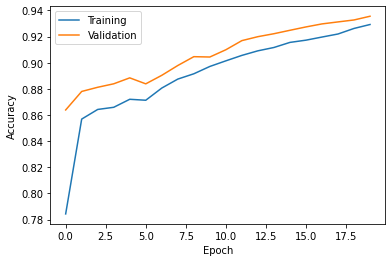

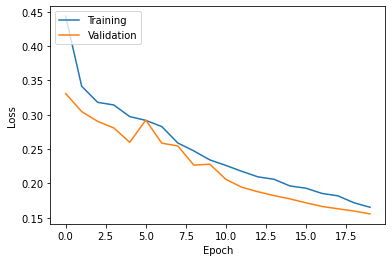

In [ ]:
# Plot accuracy and loss for U-Net

## Accuracy
plt.plot(unet_4d_atlantic_history['accuracy'])
plt.plot(unet_4d_atlantic_history['val_accuracy'])
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper left')
plt.show()

## Loss
plt.plot(unet_4d_atlantic_history['loss'])
plt.plot(unet_4d_atlantic_history['val_loss'])
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper left')

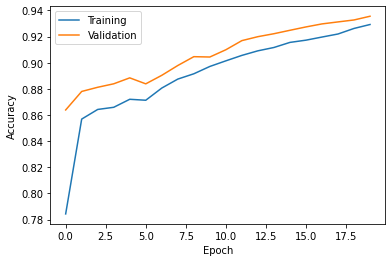

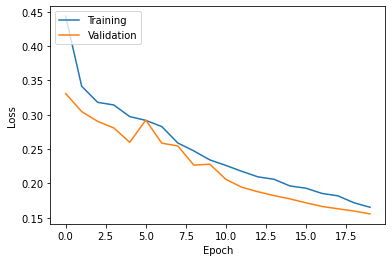

In [ ]:
# Plot accuracy and loss for Attention U-Net

## Accuracy
plt.plot(attention_unet_4d_atlantic_history['accuracy'])
plt.plot(attention_unet_4d_atlantic_history['val_accuracy'])
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper left')
plt.show()

## Loss
plt.plot(attention_unet_4d_atlantic_history['loss'])
plt.plot(attention_unet_4d_atlantic_history['val_loss'])
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper left')

In [ ]:
# Scores of each model
unet_4d_atlantic_score = (score_eval2(unet_4d_atlantic, validation_images3, validation_masks3))
am_unet_4d_atlantic_score = (score_eval2(attention_unet_4d_atlantic, validation_images3, validation_masks3))

# Precision and recall of each model
unet_4d_atlantic_precision = (precision_eval(unet_4d_atlantic, validation_images3, validation_masks3))
am_unet_4d_atlantic_precision = (precision_eval(attention_unet_4d_atlantic, validation_images3, validation_masks3))

unet_4d_atlantic_recall = (recall_eval(unet_4d_atlantic, validation_images3, validation_masks3))
am_unet_4d_atlantic_recall = (recall_eval(attention_unet_4d_atlantic, validation_images3, validation_masks3))

# F1-scores of each model
unet_4d_atlantic_f1_score = (f1_score_eval_basic(unet_4d_atlantic_precision, unet_4d_atlantic_recall))
am_unet_4d_atlantic_f1_score = (f1_score_eval_basic(am_unet_4d_atlantic_precision, am_unet_4d_atlantic_recall))

In [ ]:
# Print metrics
print('U-Net score: ', np.mean(unet_4d_atlantic_score), np.std(unet_4d_atlantic_score))
print('Attention U-Net score: ', np.mean(am_unet_4d_atlantic_score), np.std(am_unet_4d_atlantic_score))

print('U-Net precision: ', np.mean(unet_4d_atlantic_precision), np.std(unet_4d_atlantic_precision))
print('Attention U-Net precision: ', np.mean(am_unet_4d_atlantic_precision), np.std(am_unet_4d_atlantic_precision))

print('U-Net recall: ', np.mean(unet_4d_atlantic_recall), np.std(unet_4d_atlantic_recall))
print('Attention U-Net recall: ', np.mean(am_unet_4d_atlantic_recall), np.std(am_unet_4d_atlantic_recall))

print('U-Net F1-score: ', unet_4d_atlantic_f1_score)
print('Attention U-Net F1-score: ', am_unet_4d_atlantic_f1_score)

U-Net score:  0.9355057144165039 0.04636710402007658
Attention U-Net score:  0.9353220748901367 0.04893032871320888
U-Net precision:  0.9454349282513129 0.028613638758911868
Attention U-Net precision:  0.9482422397377319 0.025172300797293372
U-Net recall:  0.9355057144165039 0.04636710402007658
Attention U-Net recall:  0.9353220748901367 0.04893032871320888
U-Net F1-score:  0.9404441138914349
Attention U-Net F1-score:  0.941737844874377


### Atlantic on unseen Amazon data

In [ ]:
# Score
unet_atlantic_on_amazon_score = score_eval2(unet_4d_atlantic, validation_images2, validation_masks2)
am_unet_atlantic_on_amazon_score = score_eval2(attention_unet_4d_atlantic, validation_images2, validation_masks2)

# Precision
unet_atlantic_on_amazon_precision = (precision_eval(unet_4d_atlantic, validation_images2, validation_masks2))
am_unet_atlantic_on_amazon_precision = (precision_eval(attention_unet_4d_atlantic, validation_images2, validation_masks2))

# Recall
unet_atlantic_on_amazon_recall = (recall_eval(unet_4d_atlantic, validation_images2, validation_masks2))
am_unet_atlantic_on_amazon_recall = (recall_eval(attention_unet_4d_atlantic, validation_images2, validation_masks2))

# F1-scores of each model
unet_atlantic_on_amazon_f1_score = (f1_score_eval_basic(unet_atlantic_on_amazon_precision, unet_atlantic_on_amazon_recall))
am_unet_atlantic_on_amazon_f1_score = (f1_score_eval_basic(am_unet_atlantic_on_amazon_precision, am_unet_atlantic_on_amazon_recall))

In [ ]:
# Print metrics
print('U-Net score: ', np.mean(unet_atlantic_on_amazon_score), np.std(unet_atlantic_on_amazon_score))
print('Attention U-Net score: ', np.mean(am_unet_atlantic_on_amazon_score), np.std(am_unet_atlantic_on_amazon_score))

print('U-Net precision: ', np.mean(unet_atlantic_on_amazon_precision), np.std(unet_atlantic_on_amazon_precision))
print('Attention U-Net precision: ', np.mean(am_unet_atlantic_on_amazon_precision), np.std(am_unet_atlantic_on_amazon_precision))

print('U-Net recall: ', np.mean(unet_atlantic_on_amazon_recall), np.std(unet_atlantic_on_amazon_recall))
print('Attention U-Net recall: ', np.mean(am_unet_atlantic_on_amazon_recall), np.std(am_unet_atlantic_on_amazon_recall))

print('U-Net F1-score: ', unet_atlantic_on_amazon_f1_score)
print('Attention U-Net F1-score: ', am_unet_atlantic_on_amazon_f1_score)

U-Net score:  0.9137404251098633 0.07818801720147346
Attention U-Net score:  0.9176633834838868 0.06524485955666726
U-Net precision:  0.9408220248157325 0.04260998397604987
Attention U-Net precision:  0.9406164661259162 0.040584368754444364
U-Net recall:  0.9137404251098633 0.07818801720147346
Attention U-Net recall:  0.9176633834838868 0.06524485955666726
U-Net F1-score:  0.9270834928662975
Attention U-Net F1-score:  0.9289981689754762


### Amazon and Atlantic unseen test data

In [ ]:
# Amazon trained model on Amazon test data
# Scores of each model
unet_4d_score_test = (score_eval2(unet_4d, test_images2, test_masks2))
am_unet_4d_score_test = (score_eval2(attention_unet_4d, test_images2, test_masks2))

# Precision and recall of each model
unet_4d_precision_test = (precision_eval(unet_4d, test_images2, test_masks2))
am_unet_4d_precision_test = (precision_eval(attention_unet_4d, test_images2, test_masks2))

unet_4d_recall_test = (recall_eval(unet_4d, test_images2, test_masks2))
am_unet_4d_recall_test = (recall_eval(attention_unet_4d, test_images2, test_masks2))

# F1-scores of each model
unet_4d_f1_score_test = (f1_score_eval_basic(unet_4d_precision_test, unet_4d_recall_test))
am_unet_4d_f1_score_test = (f1_score_eval_basic(am_unet_4d_precision_test, am_unet_4d_recall_test))

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
# Atlantic trained model on Atlantic test data
# Scores of each model
unet_4d_atlantic_score_test = (score_eval2(unet_4d_atlantic, test_images3, test_masks3))
am_unet_4d_atlantic_score_test = (score_eval2(attention_unet_4d_atlantic, test_images3, test_masks3))

# Precision and recall of each model
unet_4d_atlantic_precision_test = (precision_eval(unet_4d_atlantic, test_images3, test_masks3))
am_unet_4d_atlantic_precision_test = (precision_eval(attention_unet_4d_atlantic, test_images3, test_masks3))

unet_4d_atlantic_recall_test = (recall_eval(unet_4d_atlantic, test_images3, test_masks3))
am_unet_4d_atlantic_recall_test = (recall_eval(attention_unet_4d_atlantic, test_images3, test_masks3))

# F1-scores of each model
unet_4d_atlantic_f1_score_test = (f1_score_eval_basic(unet_4d_atlantic_precision_test, unet_4d_atlantic_recall_test))
am_unet_4d_atlantic_f1_score_test = (f1_score_eval_basic(am_unet_4d_atlantic_precision_test, am_unet_4d_atlantic_recall_test))

In [ ]:
# Print metrics for Amazon on Amazon Test set
print('U-Net score: ', np.mean(unet_4d_score_test), np.std(unet_4d_score_test))
print('Attention U-Net score: ', np.mean(am_unet_4d_score_test), np.std(am_unet_4d_score_test))

print('U-Net precision: ', np.mean(unet_4d_precision_test), np.std(unet_4d_precision_test))
print('Attention U-Net precision: ', np.mean(am_unet_4d_precision_test), np.std(am_unet_4d_precision_test))

print('U-Net recall: ', np.mean(unet_4d_recall_test), np.std(unet_4d_recall_test))
print('Attention U-Net recall: ', np.mean(am_unet_4d_recall_test), np.std(am_unet_4d_recall_test))

print('U-Net F1-score: ', unet_4d_f1_score_test)
print('Attention U-Net F1-score: ', am_unet_4d_f1_score_test)

U-Net score:  0.9592618942260742 0.026417391604667682
Attention U-Net score:  0.9641162872314453 0.025662120151879523
U-Net precision:  0.9625063260917978 0.022230480106680366
Attention U-Net precision:  0.9674319534486948 0.021048098489469824
U-Net recall:  0.9592618942260742 0.026417391604667682
Attention U-Net recall:  0.9641162872314453 0.025662120151879523
U-Net F1-score:  0.9608813714472588
Attention U-Net F1-score:  0.9657712745290691


In [ ]:
# Print metrics for Atlantic on Atlantic Test set
print('U-Net score: ', np.mean(unet_4d_atlantic_score_test), np.std(unet_4d_atlantic_score_test))
print('Attention U-Net score: ', np.mean(am_unet_4d_atlantic_score_test), np.std(am_unet_4d_atlantic_score_test))

print('U-Net precision: ', np.mean(unet_4d_atlantic_precision_test), np.std(unet_4d_atlantic_precision_test))
print('Attention U-Net precision: ', np.mean(am_unet_4d_atlantic_precision_test), np.std(am_unet_4d_atlantic_precision_test))

print('U-Net recall: ', np.mean(unet_4d_atlantic_recall_test), np.std(unet_4d_atlantic_recall_test))
print('Attention U-Net recall: ', np.mean(am_unet_4d_atlantic_recall_test), np.std(am_unet_4d_atlantic_recall_test))

print('U-Net F1-score: ', unet_4d_atlantic_f1_score_test)
print('Attention U-Net F1-score: ', am_unet_4d_atlantic_f1_score_test)

U-Net score:  0.924553108215332 0.07535623807570371
Attention U-Net score:  0.9237554550170899 0.07488598185833091
U-Net precision:  0.9434097955847133 0.03273492889308469
Attention U-Net precision:  0.944694025685098 0.0316545593852273
U-Net recall:  0.924553108215332 0.07535623807570371
Attention U-Net recall:  0.9237554550170899 0.07488598185833091
U-Net F1-score:  0.9338862747801174
Attention U-Net F1-score:  0.934107417472914


## ResNet50-SegNet

In [ ]:
# Load ResNet models and history stats
resnet_3d = load_model('resnet50segnet-3d.hdf5')
resnet_4d_amazon = load_model('resnet50segnet-4d.hdf5')
resnet_4d_atlantic = load_model('resnet50segnet-4d-atlantic.hdf5')

resnet_3d_history = np.load('resnet50segnet-3d-history.npy', allow_pickle='TRUE').item()
resnet50segnet_4d_amazon_history = np.load('resnet50segnet-4d-history.npy', allow_pickle='TRUE').item()
resnet50segnet_4d_atlantic_history = np.load('resnet50segnet-4d-history-atlantic.npy', allow_pickle='TRUE').item()

In [ ]:
# Metrics of each model on respective datasets

# Score
resnet_3d_score = (score_eval(resnet_3d, validation_images, validation_masks))
resnet_4d_amazon_score = (score_eval2(resnet_4d_amazon, validation_images2, validation_masks2))
resnet_4d_atlantic_score = (score_eval2(resnet_4d_atlantic, validation_images3, validation_masks3))

# Precision and recall
resnet_3d_precision = (precision_eval(resnet_3d, validation_images, validation_masks))
resnet_4d_amazon_precision = (precision_eval(resnet_4d_amazon, validation_images2, validation_masks2))
resnet_4d_atlantic_precision = (precision_eval(resnet_4d_atlantic, validation_images3, validation_masks3))

resnet_3d_recall = (recall_eval(resnet_3d, validation_images, validation_masks))
resnet_4d_amazon_recall = (recall_eval(resnet_4d_amazon, validation_images2, validation_masks2))
resnet_4d_atlantic_recall = (recall_eval(resnet_4d_atlantic, validation_images3, validation_masks3))

# F1-score
resnet_3d_f1_score = (f1_score_eval_basic(resnet_3d_precision, resnet_3d_recall))
resnet_4d_amazon_f1_score = (f1_score_eval_basic(resnet_4d_amazon_precision, resnet_4d_amazon_recall))
resnet_4d_atlantic_f1_score = (f1_score_eval_basic(resnet_4d_atlantic_precision, resnet_4d_atlantic_recall))

In [ ]:
# Metrics of 4-dim Amazon trained model on Atlantic data and vice versa

# Score
resnet_4d_amazon_on_atlantic_score = (score_eval2(resnet_4d_amazon, validation_images3, validation_masks3))
resnet_4d_atlantic_on_amazon_score = (score_eval2(resnet_4d_atlantic, validation_images2, validation_masks2))

# Precision and recall
resnet_4d_amazon_on_atlantic_precision = (precision_eval(resnet_4d_amazon, validation_images3, validation_masks3))
resnet_4d_atlantic_on_amazon_precision = (precision_eval(resnet_4d_atlantic, validation_images2, validation_masks2))

resnet_4d_amazon_on_atlantic_recall = (recall_eval(resnet_4d_amazon, validation_images3, validation_masks3))
resnet_4d_atlantic_on_amazon_recall = (recall_eval(resnet_4d_atlantic, validation_images2, validation_masks2))

# F1-score
resnet_4d_amazon_on_atlantic_f1_score = (f1_score_eval_basic(resnet_4d_amazon_on_atlantic_precision, resnet_4d_amazon_on_atlantic_recall))
resnet_4d_atlantic_on_amazon_f1_score = (f1_score_eval_basic(resnet_4d_atlantic_on_amazon_precision, resnet_4d_atlantic_on_amazon_recall))

In [ ]:
# Print metrics
print('Accuracy | Precision | Recall | F1-score')
print('ResNet 3-dim: ', np.mean(resnet_3d_score), np.mean(resnet_3d_precision), np.mean(resnet_3d_recall), resnet_3d_f1_score)
print('ResNet 3-dim: ', np.std(resnet_3d_score), np.std(resnet_3d_precision), np.std(resnet_3d_recall), resnet_3d_f1_score)
print('----')
print('ResNet 4-dim Amazon: ', np.mean(resnet_4d_amazon_score), np.mean(resnet_4d_amazon_precision), np.mean(resnet_4d_amazon_recall), resnet_4d_amazon_f1_score)
print('ResNet 4-dim Amazon: ', np.std(resnet_4d_amazon_score), np.std(resnet_4d_amazon_precision), np.std(resnet_4d_amazon_recall), resnet_4d_amazon_f1_score)
print('----')
print('ResNet 4-dim Atlantic: ', np.mean(resnet_4d_atlantic_score), np.mean(resnet_4d_atlantic_precision), np.mean(resnet_4d_atlantic_recall), resnet_4d_atlantic_f1_score)
print('ResNet 4-dim Atlantic: ', np.std(resnet_4d_atlantic_score), np.std(resnet_4d_atlantic_precision), np.std(resnet_4d_atlantic_recall), resnet_4d_atlantic_f1_score)
print('----')
print('ResNet 4-dim Amazon on Atlantic: ', np.mean(resnet_4d_amazon_on_atlantic_score), np.mean(resnet_4d_amazon_on_atlantic_precision), np.mean(resnet_4d_amazon_on_atlantic_recall), resnet_4d_amazon_on_atlantic_f1_score)
print('ResNet 4-dim Amazon on Atlantic: ', np.std(resnet_4d_amazon_on_atlantic_score), np.std(resnet_4d_amazon_on_atlantic_precision), np.std(resnet_4d_amazon_on_atlantic_recall), resnet_4d_amazon_on_atlantic_f1_score)
print('----')
print('ResNet 4-dim Atlantic on Amazon: ', np.mean(resnet_4d_atlantic_on_amazon_score), np.mean(resnet_4d_atlantic_on_amazon_precision), np.mean(resnet_4d_atlantic_on_amazon_recall), resnet_4d_atlantic_on_amazon_f1_score)
print('ResNet 4-dim Atlantic on Amazon: ', np.std(resnet_4d_atlantic_on_amazon_score), np.std(resnet_4d_atlantic_on_amazon_precision), np.std(resnet_4d_atlantic_on_amazon_recall), resnet_4d_atlantic_on_amazon_f1_score)


Accuracy | Precision | Recall | F1-score
ResNet 3-dim:  0.9473197937011719 0.952620391347762 0.9473197937011719 0.9499626985192156
ResNet 3-dim:  0.041341966934698056 0.03403995682151331 0.041341966934698056 0.9499626985192156
----
ResNet 4-dim Amazon:  0.9706111907958984 0.9728053208974202 0.9706111907958984 0.9717070172529576
ResNet 4-dim Amazon:  0.022188586908017765 0.019990877521858477 0.022188586908017765 0.9717070172529576
----
ResNet 4-dim Atlantic:  0.9347864532470703 0.9442208105081294 0.9347864532470703 0.9394799472706677
ResNet 4-dim Atlantic:  0.04299348831670498 0.02795523959208652 0.04299348831670498 0.9394799472706677
----
ResNet 4-dim Amazon on Atlantic:  0.8732088851928711 0.9183430334570407 0.8732088851928711 0.8952074323070319
ResNet 4-dim Amazon on Atlantic:  0.1121457620509794 0.04200027091700165 0.1121457620509794 0.8952074323070319
----
ResNet 4-dim Atlantic on Amazon:  0.9143844223022461 0.9376983462324084 0.9143844223022461 0.9258946470214936
ResNet 4-dim Atla

### Amazon and Atlantic unseen test datasets

In [ ]:
# Amazon trained model on Amazon test data
# Scores of each model
resnet_4d_score_test = (score_eval2(resnet_4d_amazon, test_images2, test_masks2))

# Precision and recall of each model
resnet_4d_precision_test = (precision_eval(resnet_4d_amazon, test_images2, test_masks2))
resnet_4d_recall_test = (recall_eval(resnet_4d_amazon, test_images2, test_masks2))

# F1-scores of each model
resnet_4d_f1_score_test = (f1_score_eval_basic(resnet_4d_precision_test, resnet_4d_recall_test))

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
# Atlantic trained model on Atlantic test data
# Scores of each model
resnet_4d_atlantic_score_test = (score_eval2(resnet_4d_atlantic, test_images3, test_masks3))

# Precision and recall of each model
resnet_4d_atlantic_precision_test = (precision_eval(resnet_4d_atlantic, test_images3, test_masks3))
resnet_4d_atlantic_recall_test = (recall_eval(resnet_4d_atlantic, test_images3, test_masks3))

# F1-scores of each model
resnet_4d_atlantic_f1_score_test = (f1_score_eval_basic(resnet_4d_atlantic_precision_test, resnet_4d_atlantic_recall_test))

In [ ]:
# Print metrics for Amazon on Amazon Test set
print('ResNet score: ', np.mean(resnet_4d_score_test), np.std(resnet_4d_score_test))
print('ResNet precision: ', np.mean(resnet_4d_precision_test), np.std(resnet_4d_precision_test))
print('ResNet recall: ', np.mean(resnet_4d_recall_test), np.std(resnet_4d_recall_test))
print('ResNet F1-score: ', resnet_4d_f1_score_test)

ResNet score:  0.9689271926879883 0.021182154938242815
ResNet precision:  0.9706046439633728 0.018374828703889644
ResNet recall:  0.9689271926879883 0.021182154938242815
ResNet F1-score:  0.9697651929334162


In [ ]:
# Print metrics for Atlantic on Atlantic Test set
print('ResNet score: ', np.mean(resnet_4d_atlantic_score_test), np.std(resnet_4d_atlantic_score_test))
print('ResNet precision: ', np.mean(resnet_4d_atlantic_precision_test), np.std(resnet_4d_atlantic_precision_test))
print('ResNet recall: ', np.mean(resnet_4d_atlantic_recall_test), np.std(resnet_4d_atlantic_recall_test))
print('ResNet F1-score: ', resnet_4d_atlantic_f1_score_test)

ResNet score:  0.9250993728637695 0.066819550198767
ResNet precision:  0.9406290506072839 0.0320231983389741
ResNet recall:  0.9250993728637695 0.066819550198767
ResNet F1-score:  0.9327995799038561


## FCN32-VGG16

In [ ]:
FCN32_3d = fcn_32(input_size=(512,512,3), lr = 0.0001)
FCN32_4d_amazon = fcn_32(input_size=(512,512,4), lr = 0.0001)
FCN32_4d_atlantic = fcn_32(input_size=(512,512,4), lr = 0.0001)

# Load FCN models and history stats
FCN32_3d.load_weights('fcn32-3d-weights.h5')
FCN32_4d_amazon.load_weights('fcn32-4d-weights.h5')
FCN32_4d_atlantic.load_weights('fcn32-4d-atlantic-weights.h5')
fcn32_3d = FCN32_3d
fcn32_4d_amazon = FCN32_4d_amazon
fcn32_4d_atlantic = FCN32_4d_atlantic

fcn32_3d_history = np.load('fcn32-3d-history.npy', allow_pickle='TRUE').item()
fcn32_4d_amazon_history = np.load('fcn32-4d-history.npy', allow_pickle='TRUE').item()
fcn32_4d_atlantic_history = np.load('fcn32-4d-atlantic-history.npy', allow_pickle='TRUE').item()

In [ ]:
# Metrics of each model on respective datasets

# Score
fcn32_3d_score = (score_eval(fcn32_3d, validation_images, validation_masks))
fcn32_4d_amazon_score = (score_eval2(fcn32_4d_amazon, validation_images2, validation_masks2))
fcn32_4d_atlantic_score = (score_eval2(fcn32_4d_atlantic, validation_images3, validation_masks3))

# Precision and recall
fcn32_3d_precision = (precision_eval(fcn32_3d, validation_images, validation_masks))
fcn32_4d_amazon_precision = (precision_eval(fcn32_4d_amazon, validation_images2, validation_masks2))
fcn32_4d_atlantic_precision = (precision_eval(fcn32_4d_atlantic, validation_images3, validation_masks3))

fcn32_3d_recall = (recall_eval(fcn32_3d, validation_images, validation_masks))
fcn32_4d_amazon_recall = (recall_eval(fcn32_4d_amazon, validation_images2, validation_masks2))
fcn32_4d_atlantic_recall = (recall_eval(fcn32_4d_atlantic, validation_images3, validation_masks3))

# F1-score
fcn32_3d_f1_score = (f1_score_eval_basic(fcn32_3d_precision, fcn32_3d_recall))
fcn32_4d_amazon_f1_score = (f1_score_eval_basic(fcn32_4d_amazon_precision, fcn32_4d_amazon_recall))
fcn32_4d_atlantic_f1_score = (f1_score_eval_basic(fcn32_4d_atlantic_precision, fcn32_4d_atlantic_recall))

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
# Metrics of 4-dim Amazon trained model on Atlantic data and vice versa

# Score
fcn32_4d_amazon_on_atlantic_score = (score_eval2(fcn32_4d_amazon, validation_images3, validation_masks3))
fcn32_4d_atlantic_on_amazon_score = (score_eval2(fcn32_4d_atlantic, validation_images2, validation_masks2))

# Precision and recall
fcn32_4d_amazon_on_atlantic_precision = (precision_eval(fcn32_4d_amazon, validation_images3, validation_masks3))
fcn32_4d_atlantic_on_amazon_precision = (precision_eval(fcn32_4d_atlantic, validation_images2, validation_masks2))

fcn32_4d_amazon_on_atlantic_recall = (recall_eval(fcn32_4d_amazon, validation_images3, validation_masks3))
fcn32_4d_atlantic_on_amazon_recall = (recall_eval(fcn32_4d_atlantic, validation_images2, validation_masks2))

# F1-score
fcn32_4d_amazon_on_atlantic_f1_score = (f1_score_eval_basic(fcn32_4d_amazon_on_atlantic_precision, fcn32_4d_amazon_on_atlantic_recall))
fcn32_4d_atlantic_on_amazon_f1_score = (f1_score_eval_basic(fcn32_4d_atlantic_on_amazon_precision, fcn32_4d_atlantic_on_amazon_recall))

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
# Print metrics
print('Accuracy | Precision | Recall | F1-score')
print('FCN32 3-dim: ', np.mean(fcn32_3d_score), np.mean(fcn32_3d_precision), np.mean(fcn32_3d_recall), fcn32_3d_f1_score)
print('FCN32 3-dim: ', np.std(fcn32_3d_score), np.std(fcn32_3d_precision), np.std(fcn32_3d_recall), fcn32_3d_f1_score)
print('----')
print('FCN32 4-dim Amazon: ', np.mean(fcn32_4d_amazon_score), np.mean(fcn32_4d_amazon_precision), np.mean(fcn32_4d_amazon_recall), fcn32_4d_amazon_f1_score)
print('FCN32 4-dim Amazon: ', np.std(fcn32_4d_amazon_score), np.std(fcn32_4d_amazon_precision), np.std(fcn32_4d_amazon_recall), fcn32_4d_amazon_f1_score)
print('----')
print('FCN32 4-dim Atlantic: ', np.mean(fcn32_4d_atlantic_score), np.mean(fcn32_4d_atlantic_precision), np.mean(fcn32_4d_atlantic_recall), fcn32_4d_atlantic_f1_score)
print('FCN32 4-dim Atlantic: ', np.std(fcn32_4d_atlantic_score), np.std(fcn32_4d_atlantic_precision), np.std(fcn32_4d_atlantic_recall), fcn32_4d_atlantic_f1_score)
print('----')
print('FCN32 4-dim Amazon on Atlantic: ', np.mean(fcn32_4d_amazon_on_atlantic_score), np.mean(fcn32_4d_amazon_on_atlantic_precision), np.mean(fcn32_4d_amazon_on_atlantic_recall), fcn32_4d_amazon_on_atlantic_f1_score)
print('FCN32 4-dim Amazon on Atlantic: ', np.std(fcn32_4d_amazon_on_atlantic_score), np.std(fcn32_4d_amazon_on_atlantic_precision), np.std(fcn32_4d_amazon_on_atlantic_recall), fcn32_4d_amazon_on_atlantic_f1_score)
print('----')
print('FCN32 4-dim Atlantic on Amazon: ', np.mean(fcn32_4d_atlantic_on_amazon_score), np.mean(fcn32_4d_atlantic_on_amazon_precision), np.mean(fcn32_4d_atlantic_on_amazon_recall), fcn32_4d_atlantic_on_amazon_f1_score)
print('FCN32 4-dim Atlantic on Amazon: ', np.std(fcn32_4d_atlantic_on_amazon_score), np.std(fcn32_4d_atlantic_on_amazon_precision), np.std(fcn32_4d_atlantic_on_amazon_recall), fcn32_4d_atlantic_on_amazon_f1_score)


Accuracy | Precision | Recall | F1-score
FCN32 3-dim:  0.9044364929199219 0.9066910158057679 0.9044364929199219 0.9055623511282801
FCN32 3-dim:  0.07493092368522997 0.06798179517453329 0.07493092368522997 0.9055623511282801
----
FCN32 4-dim Amazon:  0.9195623016357422 0.9193059592359851 0.9195623016357422 0.9194341125685082
FCN32 4-dim Amazon:  0.043886387687458006 0.041286396845759125 0.043886387687458006 0.9194341125685082
----
FCN32 4-dim Atlantic:  0.8270412063598633 0.826683514585432 0.8270412063598633 0.8268623217892428
FCN32 4-dim Atlantic:  0.06254329584552473 0.06584561995332405 0.06254329584552473 0.8268623217892428
----
FCN32 4-dim Amazon on Atlantic:  0.7706329345703125 0.82481485147684 0.7706329345703125 0.7968038754130535
FCN32 4-dim Amazon on Atlantic:  0.13241930566213544 0.05617610284351866 0.13241930566213544 0.7968038754130535
----
FCN32 4-dim Atlantic on Amazon:  0.8300349044799805 0.8881535746785433 0.8300349044799805 0.8581112915887994
FCN32 4-dim Atlantic on Amaz

### Amazon and Atlantic unseen test datasets

In [ ]:
# Amazon trained model on Amazon test data
# Scores of each model
fcn32_4d_score_test = (score_eval2(fcn32_4d_amazon, test_images2, test_masks2))

# Precision and recall of each model
fcn32_4d_precision_test = (precision_eval(fcn32_4d_amazon, test_images2, test_masks2))
fcn32_4d_recall_test = (recall_eval(fcn32_4d_amazon, test_images2, test_masks2))

# F1-scores of each model
fcn32_4d_f1_score_test = (f1_score_eval_basic(fcn32_4d_precision_test, fcn32_4d_recall_test))

In [ ]:
# Atlantic trained model on Atlantic test data
# Scores of each model
fcn32_4d_atlantic_score_test = (score_eval2(fcn32_4d_atlantic, test_images3, test_masks3))

# Precision and recall of each model
fcn32_4d_atlantic_precision_test = (precision_eval(fcn32_4d_atlantic, test_images3, test_masks3))
fcn32_4d_atlantic_recall_test = (recall_eval(fcn32_4d_atlantic, test_images3, test_masks3))

# F1-scores of each model
fcn32_4d_atlantic_f1_score_test = (f1_score_eval_basic(fcn32_4d_atlantic_precision_test, fcn32_4d_atlantic_recall_test))

In [ ]:
# Print metrics for Amazon on Amazon Test set
print('FCN32 score: ', np.mean(fcn32_4d_score_test), np.std(fcn32_4d_score_test))
print('FCN32 precision: ', np.mean(fcn32_4d_precision_test), np.std(fcn32_4d_precision_test))
print('FCN32 recall: ', np.mean(fcn32_4d_recall_test), np.std(fcn32_4d_recall_test))
print('FCN32 F1-score: ', fcn32_4d_f1_score_test)

FCN32 score:  0.9189081192016602 0.03173571793757352
FCN32 precision:  0.9200968253813897 0.02934689140695418
FCN32 recall:  0.9189081192016602 0.03173571793757352
FCN32 F1-score:  0.9195020881102899


In [ ]:
# Print metrics for Atlantic on Atlantic Test set
print('FCN32 score: ', np.mean(fcn32_4d_atlantic_score_test), np.std(fcn32_4d_atlantic_score_test))
print('FCN32 precision: ', np.mean(fcn32_4d_atlantic_precision_test), np.std(fcn32_4d_atlantic_precision_test))
print('FCN32 recall: ', np.mean(fcn32_4d_atlantic_recall_test), np.std(fcn32_4d_atlantic_recall_test))
print('FCN32 F1-score: ', fcn32_4d_atlantic_f1_score_test)

FCN32 score:  0.8076122283935547 0.07907718791475604
FCN32 precision:  0.8181134017070271 0.05355907100498819
FCN32 recall:  0.8076122283935547 0.07907718791475604
FCN32 F1-score:  0.8128288995362221


# Produce metric datasets for export

## 3-dim data

In [ ]:
scores_3d = [unet_score, am_unet_score, resnet_3d_score, fcn32_3d_score]
precision_3d = [unet_precision, am_unet_precision, resnet_3d_precision, fcn32_3d_precision]
recall_3d = [unet_recall, am_unet_recall, resnet_3d_recall, fcn32_3d_recall]
f1_scores_3d = [unet_f1_score, am_unet_f1_score, resnet_3d_f1_score, fcn32_3d_f1_score]

import pandas as pd
metrics_3d = {'classifier': ['U-Net', 'Attention U-Net', 'ResNet50-SegNet', 'FCN32-VGG16'],
              'accuracy': [np.mean(n) for n in scores_3d],
              'precision': [np.mean(n) for n in precision_3d],
              'recall': [np.mean(n) for n in recall_3d],
              'f1_score': [np.mean(n) for n in f1_scores_3d],
              'accuracy_std': [np.std(n) for n in scores_3d],
              'precision_std': [np.std(n) for n in precision_3d],
              'recall_std': [np.std(n) for n in recall_3d]
              }
metrics_3d = pd.DataFrame(metrics_3d)
metrics_3d.to_csv('metrics_3d.csv')

## 4-band Amazon data

In [ ]:
scores_4d = [unet_4d_score, am_unet_4d_score, resnet_4d_amazon_score, fcn32_4d_amazon_score]
precision_4d = [unet_4d_precision, am_unet_4d_precision, resnet_4d_amazon_precision, fcn32_4d_amazon_precision]
recall_4d = [unet_4d_recall, am_unet_4d_recall, resnet_4d_amazon_recall, fcn32_4d_amazon_recall]
f1_scores_4d = [unet_4d_f1_score, am_unet_4d_f1_score, resnet_4d_amazon_f1_score, fcn32_4d_amazon_f1_score]

metrics_4d = {'classifier': ['U-Net', 'Attention U-Net', 'ResNet50-SegNet', 'FCN32-VGG16'],
              'accuracy': [np.mean(n) for n in scores_4d],
              'precision': [np.mean(n) for n in precision_4d],
              'recall': [np.mean(n) for n in recall_4d],
              'f1_score': [np.mean(n) for n in f1_scores_4d],
              'accuracy_std': [np.std(n) for n in scores_4d],
              'precision_std': [np.std(n) for n in precision_4d],
              'recall_std': [np.std(n) for n in recall_4d]
              }
metrics_4d = pd.DataFrame(metrics_4d)
metrics_4d.to_csv('metrics_4d_amazon.csv')

## 4-band Atlantic Forest data

In [ ]:
scores_4d_atl = [unet_4d_atlantic_score, am_unet_4d_atlantic_score, resnet_4d_atlantic_score, fcn32_4d_atlantic_score]
precision_4d_atl = [unet_4d_atlantic_precision, am_unet_4d_atlantic_precision, resnet_4d_atlantic_precision, fcn32_4d_atlantic_precision]
recall_4d_atl = [unet_4d_atlantic_recall, am_unet_4d_atlantic_recall, resnet_4d_atlantic_recall, fcn32_4d_atlantic_recall]
f1_scores_4d_atl = [unet_4d_atlantic_f1_score, am_unet_4d_atlantic_f1_score, resnet_4d_atlantic_f1_score, fcn32_4d_atlantic_f1_score]

metrics_4d_atl = {'classifier': ['U-Net', 'Attention U-Net', 'ResNet50-SegNet', 'FCN32-VGG16'],
              'accuracy': [np.mean(n) for n in scores_4d_atl],
              'precision': [np.mean(n) for n in precision_4d_atl],
              'recall': [np.mean(n) for n in recall_4d_atl],
              'f1_score': [np.mean(n) for n in f1_scores_4d_atl],
              'accuracy_std': [np.std(n) for n in scores_4d_atl],
              'precision_std': [np.std(n) for n in precision_4d_atl],
              'recall_std': [np.std(n) for n in recall_4d_atl]
              }
metrics_4d_atl = pd.DataFrame(metrics_4d_atl)
metrics_4d_atl.to_csv('metrics_4d_atlantic_forest.csv')

## Test set data

In [91]:
scores_4d_test = [unet_4d_score_test, am_unet_4d_score_test, resnet_4d_score_test, fcn32_4d_score_test]
precision_4d_test = [unet_4d_precision_test, am_unet_4d_precision_test, resnet_4d_precision_test, fcn32_4d_precision_test]
recall_4d_test = [unet_4d_recall_test, am_unet_4d_recall_test, resnet_4d_recall_test, fcn32_4d_recall_test]
f1_scores_4d_test = [unet_4d_f1_score_test, am_unet_4d_f1_score_test, resnet_4d_f1_score_test, fcn32_4d_f1_score_test]

metrics_4d_test = {'classifier': ['U-Net', 'Attention U-Net', 'ResNet50-SegNet', 'FCN32-VGG16'],
              'accuracy': [np.mean(n) for n in scores_4d_test],
              'precision': [np.mean(n) for n in precision_4d_test],
              'recall': [np.mean(n) for n in recall_4d_test],
              'f1_score': [np.mean(n) for n in f1_scores_4d_test],
              'accuracy_std': [np.std(n) for n in scores_4d_test],
              'precision_std': [np.std(n) for n in precision_4d_test],
              'recall_std': [np.std(n) for n in recall_4d_test]
              }
metrics_4d_test = pd.DataFrame(metrics_4d_test)
metrics_4d_test.to_csv('metrics_4d_amazon_test.csv')

In [92]:
scores_4d_atl_test = [unet_4d_atlantic_score_test, am_unet_4d_atlantic_score_test, resnet_4d_atlantic_score_test, fcn32_4d_atlantic_score_test]
precision_4d_atl_test = [unet_4d_atlantic_precision_test, am_unet_4d_atlantic_precision_test, resnet_4d_atlantic_precision_test, fcn32_4d_atlantic_precision_test]
recall_4d_atl_test = [unet_4d_atlantic_recall_test, am_unet_4d_atlantic_recall_test, resnet_4d_atlantic_recall_test, fcn32_4d_atlantic_recall_test]
f1_scores_4d_atl_test = [unet_4d_atlantic_f1_score_test, am_unet_4d_atlantic_f1_score_test, resnet_4d_atlantic_f1_score_test, fcn32_4d_atlantic_f1_score_test]

metrics_4d_atl_test = {'classifier': ['U-Net', 'Attention U-Net', 'ResNet50-SegNet', 'FCN32-VGG16'],
              'accuracy': [np.mean(n) for n in scores_4d_atl_test],
              'precision': [np.mean(n) for n in precision_4d_atl_test],
              'recall': [np.mean(n) for n in recall_4d_atl_test],
              'f1_score': [np.mean(n) for n in f1_scores_4d_atl_test],
              'accuracy_std': [np.std(n) for n in scores_4d_atl_test],
              'precision_std': [np.std(n) for n in precision_4d_atl_test],
              'recall_std': [np.std(n) for n in recall_4d_atl_test]
              }
metrics_4d_atl_test = pd.DataFrame(metrics_4d_atl_test)
metrics_4d_atl_test.to_csv('metrics_4d_atlantic_forest_test.csv')

## Testing on opposite dataset (e.g. train on Amazon, test on Atlantic)

In [94]:
scores_amazon_on_atlantic = [unet_amazon_on_atlantic_score, am_unet_amazon_on_atlantic_score, resnet_4d_amazon_on_atlantic_score, fcn32_4d_amazon_on_atlantic_score]
precision_amazon_on_atlantic = [unet_amazon_on_atlantic_precision, am_unet_amazon_on_atlantic_precision, resnet_4d_amazon_on_atlantic_precision, fcn32_4d_amazon_on_atlantic_precision]
recall_amazon_on_atlantic = [unet_amazon_on_atlantic_recall, am_unet_amazon_on_atlantic_recall, resnet_4d_amazon_on_atlantic_recall, fcn32_4d_amazon_on_atlantic_recall]
f1_scores_amazon_on_atlantic = [unet_amazon_on_atlantic_f1_score, am_unet_amazon_on_atlantic_f1_score, resnet_4d_amazon_on_atlantic_f1_score, fcn32_4d_amazon_on_atlantic_f1_score]

metrics_4d_amazon_on_atlantic = {'classifier': ['U-Net', 'Attention U-Net', 'ResNet50-SegNet', 'FCN32-VGG16'],
              'accuracy': [np.mean(n) for n in scores_amazon_on_atlantic],
              'precision': [np.mean(n) for n in precision_amazon_on_atlantic],
              'recall': [np.mean(n) for n in recall_amazon_on_atlantic],
              'f1_score': [np.mean(n) for n in f1_scores_amazon_on_atlantic],
              'accuracy_std': [np.std(n) for n in scores_amazon_on_atlantic],
              'precision_std': [np.std(n) for n in precision_amazon_on_atlantic],
              'recall_std': [np.std(n) for n in recall_amazon_on_atlantic]
              }
metrics_4d_amazon_on_atlantic = pd.DataFrame(metrics_4d_amazon_on_atlantic)
metrics_4d_amazon_on_atlantic.to_csv('metrics_4d_amazon_on_atlantic.csv')

In [95]:
scores_atlantic_on_amazon = [unet_atlantic_on_amazon_score, am_unet_atlantic_on_amazon_score, resnet_4d_atlantic_on_amazon_score, fcn32_4d_atlantic_on_amazon_score]
precision_atlantic_on_amazon = [unet_atlantic_on_amazon_precision, am_unet_atlantic_on_amazon_precision, resnet_4d_atlantic_on_amazon_precision, fcn32_4d_atlantic_on_amazon_precision]
recall_atlantic_on_amazon = [unet_atlantic_on_amazon_recall, am_unet_atlantic_on_amazon_recall, resnet_4d_atlantic_on_amazon_recall, fcn32_4d_atlantic_on_amazon_recall]
f1_scores_atlantic_on_amazon = [unet_atlantic_on_amazon_f1_score, am_unet_atlantic_on_amazon_f1_score, resnet_4d_atlantic_on_amazon_f1_score, fcn32_4d_atlantic_on_amazon_f1_score]

metrics_4d_atlantic_on_amazon = {'classifier': ['U-Net', 'Attention U-Net', 'ResNet50-SegNet', 'FCN32-VGG16'],
              'accuracy': [np.mean(n) for n in scores_atlantic_on_amazon],
              'precision': [np.mean(n) for n in precision_atlantic_on_amazon],
              'recall': [np.mean(n) for n in recall_atlantic_on_amazon],
              'f1_score': [np.mean(n) for n in f1_scores_atlantic_on_amazon],
              'accuracy_std': [np.std(n) for n in scores_atlantic_on_amazon],
              'precision_std': [np.std(n) for n in precision_atlantic_on_amazon],
              'recall_std': [np.std(n) for n in recall_atlantic_on_amazon]
              }
metrics_4d_atlantic_on_amazon = pd.DataFrame(metrics_4d_atlantic_on_amazon)
metrics_4d_atlantic_on_amazon.to_csv('metrics_4d_atlantic_on_amazon.csv')